<a id='Q0'></a>
<center> <h1> Crypto Project - Bitcoin Price Machine Learning Experiment </h1> </center>
<center> <h2 class="blue-text" style="color: blue"> Time Series Machine Learning Model Evaluation </h2> </center>
<p style="margin-bottom:1cm;"></p>
<center><h4>ZHAW CAS DAENG Group 4, 09 July 2021</h4></center>
<p style="margin-bottom:1cm;"></p>

<div style="background:#06065c10;border-top:0.01cm solid #53c653;border-bottom:0.01cm solid #53c653;color:#303030">
    <div style="margin-left: 0.5cm;margin-top: 0.5cm;margin-bottom: 0.5cm">
        <p><strong>Goal: </strong>Train different machine learning models and test their relevance and performance related to their ability to predict the daily returns of Bitcoin Prices (Regression)</p>
        <p>Train and Test Algorithms, Cross-Validate, Tune Parameters, Compare Test Performance, select & store estimator models. Perform prediction test.</p>
        <p> <strong> Outline:</strong>
        <a id="P0" name="P0"></a>
        <ol>
            <li> <a href='#I'>Import Libraries & Setup Project Directory</a> </li>
            <li> <a href='#R'>Read & look at the data</a></li>
            <li> <a href='#F'>Feature Selection</a></li>
            <li> <a href='#T'>Train, Test Split & Preprocessing</a></li>
            <li> <a href='#M'>Initial model testing</a></li>
            <li> <a href='#C'>Cross validation</a></li>
            <li> <a href='#H'>Hyperparameter-tuning</a></li>
            <li> <a href='#S'>Model Selection & Performance Comparison</a></li>
            <li> <a href='#P'>Prediction and Testing</a></li>
            <li> <a href='#X'>Comparison of Model Performance</a></li>
        </ol>
    </div>
</div>

<a id='I'></a>
## <font color='darkblue'>__Import Libraries__</font>

In [1]:
# Auto ML libraries
import comet_ml
comet_ml.init()
from comet_ml import Experiment
from lime.lime_tabular import LimeTabularExplainer
import shap
from pycaret.regression import *

COMET INFO: Comet API key is valid


In [2]:
# General libraries
import os
import pathlib
import time
import warnings
import dill
warnings.filterwarnings("ignore")

In [3]:
# External data
import yfinance as yf
from ta.trend import adx, macd

In [4]:
# Data manipulation and statistical libraries
import numpy as np
import pandas as pd
from math import ceil
from scipy import stats
from scipy.stats import f_oneway
from mlxtend.evaluate import paired_ttest_5x2cv
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from patsy import dmatrices
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.compat import lzip

In [5]:
# Data visualization libraries
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [6]:
# Defining Plot Styling
sns.set_style("darkgrid")
sns.despine()
plt.rc('lines', linewidth=2, color='b')
plt.rc('font', family='sans-serif')
plt.rc('font', size=10)
plt.rc('axes', titlelocation='center')
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize='large')
plt.rc('axes', labelcolor='blue')
plt.rc('figure', titlesize='large')
plt.rc('figure.subplot', hspace='0.6')
plt.rc('figure', figsize=(16,6))
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')

<Figure size 432x288 with 0 Axes>

In [7]:
# Sckit-Learn processing libraries
from sklearn.model_selection import (train_test_split, TimeSeriesSplit, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV, 
                                     RepeatedKFold, RepeatedStratifiedKFold, GroupShuffleSplit, cross_validate)
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    max_error,
    explained_variance_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    precision_recall_curve,
    roc_curve,
    plot_roc_curve,
    plot_precision_recall_curve,
    f1_score,
    r2_score,
    roc_auc_score
)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from tscv import GapRollForward

In [8]:
# Sckit-learn model libraries
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, BayesianRidge, Lasso, LassoLars, ElasticNet, TweedieRegressor, PassiveAggressiveRegressor, SGDRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.neural_network import MLPClassifier, MLPRegressor

In [9]:
def adjusted_r2_score(y_true, y_pred, X_test):
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    adjusted_r2 = 1 - (1-r2)*(len(y_true)-1)/(len(y_true) - X_test.shape[1]-1)
    return adjusted_r2

In [10]:
# Setup the project directory
workdir = pathlib.Path().absolute()
project_dir = workdir.parent
data_path = f"{project_dir}\\00_Data\\"
print(data_path)

C:\Users\akosr\CAS_DAENG\Modul_02\crypto_project_ML\00_Data\


<a id='R'></a>
## <font color='darkblue'>__Read Data__</font>

In [11]:
# Read the Daily Returns Dataset
df_btc_united_sentiment = pd.read_csv(data_path+'bitcoin_full_daily_returns.csv')
df_btc_united_sentiment.set_index('Date', inplace=True)

In [12]:
# Select Subset of Data, based on Date - Daily Returns
initial_date = '2017-01-01'
finish_date = '2021-06-03'
df_BTC_united_returns = df_btc_united_sentiment[initial_date:finish_date]

In [13]:
# Read the Lagged Dataset
df_btc_united_lagged = pd.read_csv(data_path+'bitcoin_full_lags.csv')
df_btc_united_lagged.set_index('Date', inplace=True)

In [14]:
# Select Subset of Data, based on Date - Daily Returns with Lags
initial_date = '2017-01-01'
finish_date = '2021-06-03'
df_BTC_united_lags = df_btc_united_lagged[initial_date:finish_date]

<a id='F'></a>
## <font color='darkblue'>__Feature Selection__</font>

### Daily Returns Dataset

### Correlations

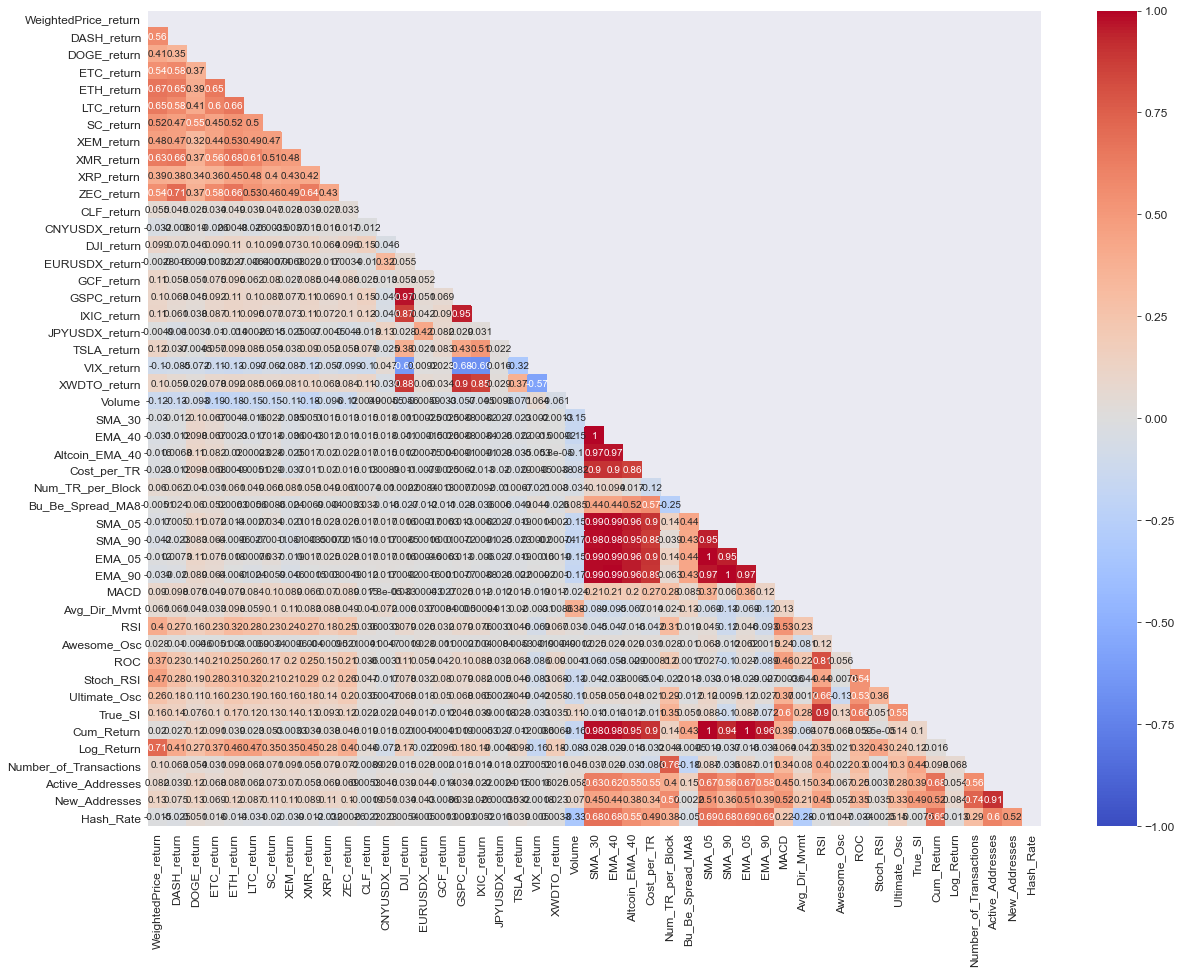

In [15]:
# Pearson Correlation Heatmap

corrmat_heat = df_BTC_united_returns.corr()
fix, ax = plt.subplots(figsize=(20,15))
matrix = np.triu(corrmat_heat)
_ax = sns.heatmap(corrmat_heat, annot=True, fmt='.2g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask=matrix)
plt.show()

### Selecting Features - considering Multicollinearity

In [16]:
df_corr = df_BTC_united_returns.drop(columns=['sentiment_elon', 'sentiment_bitcoin', 'WeightedPrice_return'])

In [17]:
corrmat_features = df_corr.corr()

In [18]:
columns = np.full(
                (corrmat_features.shape[0], ),
                True,
                dtype=bool)

In [19]:
for i in range(corrmat_features.shape[0]):
    for j in range(i+1, corrmat_features.shape[0]):
        if abs(corrmat_features.iloc[i, j]) >= 0.6:
            if columns[j]:
                columns[j] = False
selected_columns = df_corr.columns[columns]
df_features_new = df_corr[selected_columns]

In [20]:
list_selected = list(selected_columns)

In [21]:
add_col = ['sentiment_elon', 'sentiment_bitcoin', 'WeightedPrice_return']

In [22]:
list_col_final = list_selected + add_col

In [23]:
list_col_final.remove('Log_Return')

In [24]:
list_col_final

['DASH_return',
 'DOGE_return',
 'ETC_return',
 'SC_return',
 'XEM_return',
 'XRP_return',
 'CLF_return',
 'CNYUSDX_return',
 'DJI_return',
 'EURUSDX_return',
 'GCF_return',
 'JPYUSDX_return',
 'TSLA_return',
 'Volume',
 'SMA_30',
 'Num_TR_per_Block',
 'Bu_Be_Spread_MA8',
 'MACD',
 'Avg_Dir_Mvmt',
 'RSI',
 'Awesome_Osc',
 'Stoch_RSI',
 'sentiment_elon',
 'sentiment_bitcoin',
 'WeightedPrice_return']

In [25]:
df_for_model = df_BTC_united_returns[list_col_final]

In [26]:
df_for_model.head()

,DASH_return,DOGE_return,ETC_return,SC_return,XEM_return,XRP_return,CLF_return,CNYUSDX_return,DJI_return,EURUSDX_return,GCF_return,JPYUSDX_return,TSLA_return,Volume,SMA_30,Num_TR_per_Block,Bu_Be_Spread_MA8,MACD,Avg_Dir_Mvmt,RSI,Awesome_Osc,Stoch_RSI,sentiment_elon,sentiment_bitcoin,WeightedPrice_return
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.012253,-0.012549,0.000923,-0.010678,-0.061270,0.001748,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9551.105487,836.549206,1826.866242,0.177500,55.472943,60.842605,81.220741,140.026661,0.594796,neutral,positive,0.032335
2017-01-02,0.037856,-0.003227,0.003318,0.044238,-0.015263,-0.013155,-0.025875,0.000216,0.006030,-0.004569,0.009043,-0.004521,0.015443,12317.029061,845.369632,1829.880503,0.183616,58.981924,62.132935,83.870837,148.760862,0.651973,neutral,positive,0.044238
2017-01-03,0.066852,-0.005809,0.047304,-0.005809,0.015216,0.000616,0.000000,-0.000029,0.000000,-0.006360,0.000000,-0.005958,0.000000,12102.697127,854.045284,1839.410000,0.185655,62.402632,63.331099,85.063195,152.139388,0.658850,neutral,positive,-0.005809
2017-01-04,0.241382,0.027197,0.097614,0.125451,0.008355,0.037008,0.017772,-0.002270,0.003038,-0.003835,0.002930,-0.001394,0.046085,30923.989588,865.701469,2143.920000,0.187693,72.515448,64.912753,89.924766,170.463439,0.991997,neutral,positive,0.078557
2017-01-05,-0.074427,-0.026587,-0.018192,0.004315,-0.037735,-0.096155,0.009388,0.005011,-0.002150,0.007771,0.013662,0.004662,-0.001057,54107.877473,874.552546,2060.721429,0.189732,69.485477,62.807267,62.628133,177.278107,0.000000,neutral,positive,-0.072940


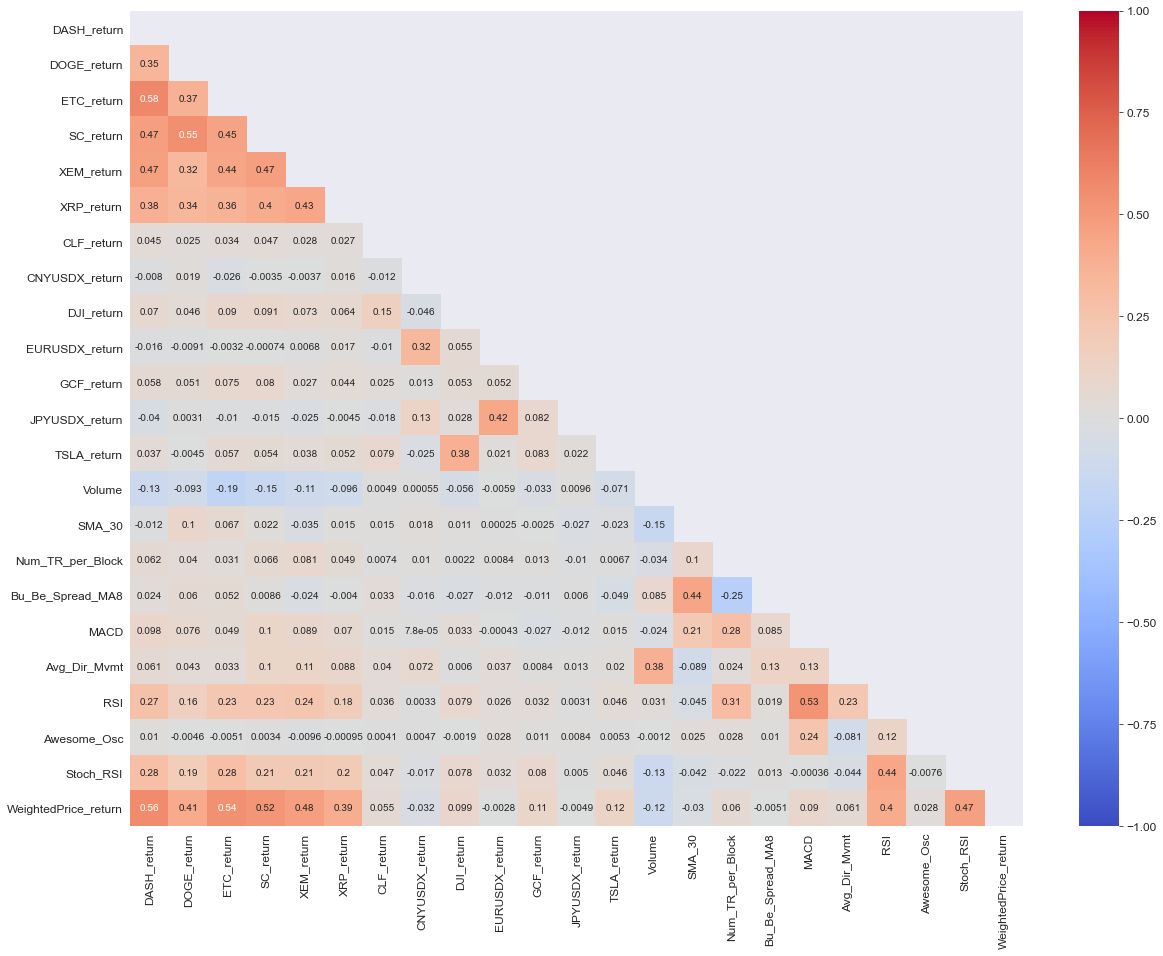

In [27]:
# Correlation Heatmap after Feature Selection

corrmat_new = df_for_model.corr()
fix, ax = plt.subplots(figsize=(20,15))
matrix = np.triu(corrmat_new)
_ax = sns.heatmap(corrmat_new, annot=True, fmt='.2g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask=matrix)
plt.show()

In [28]:
num_features = corrmat_new.columns

In [29]:
df_num = df_BTC_united_returns[num_features]

In [30]:
df_for_model.shape

(1615, 25)

In [31]:
df_for_model.isna().sum()

DASH_return             0
DOGE_return             0
ETC_return              0
SC_return               0
XEM_return              0
XRP_return              0
CLF_return              0
CNYUSDX_return          0
DJI_return              0
EURUSDX_return          0
GCF_return              0
JPYUSDX_return          0
TSLA_return             0
Volume                  0
SMA_30                  0
Num_TR_per_Block        0
Bu_Be_Spread_MA8        0
MACD                    0
Avg_Dir_Mvmt            0
RSI                     0
Awesome_Osc             0
Stoch_RSI               0
sentiment_elon          0
sentiment_bitcoin       0
WeightedPrice_return    0
dtype: int64

### Daily Returns with Lags

In [32]:
# Drop the altcoin returns
crypto_ret_list = [
    'DASH_return', 
    'DOGE_return', 
    'ETC_return', 
    'ETH_return', 
    'LTC_return', 
    'SC_return',
    'XEM_return',
    'XMR_return',
    'XRP_return',
    'ZEC_return',
]
df_BTC_united_lags_no_ALT = df_BTC_united_lags.drop(columns=crypto_ret_list)

### Correlations

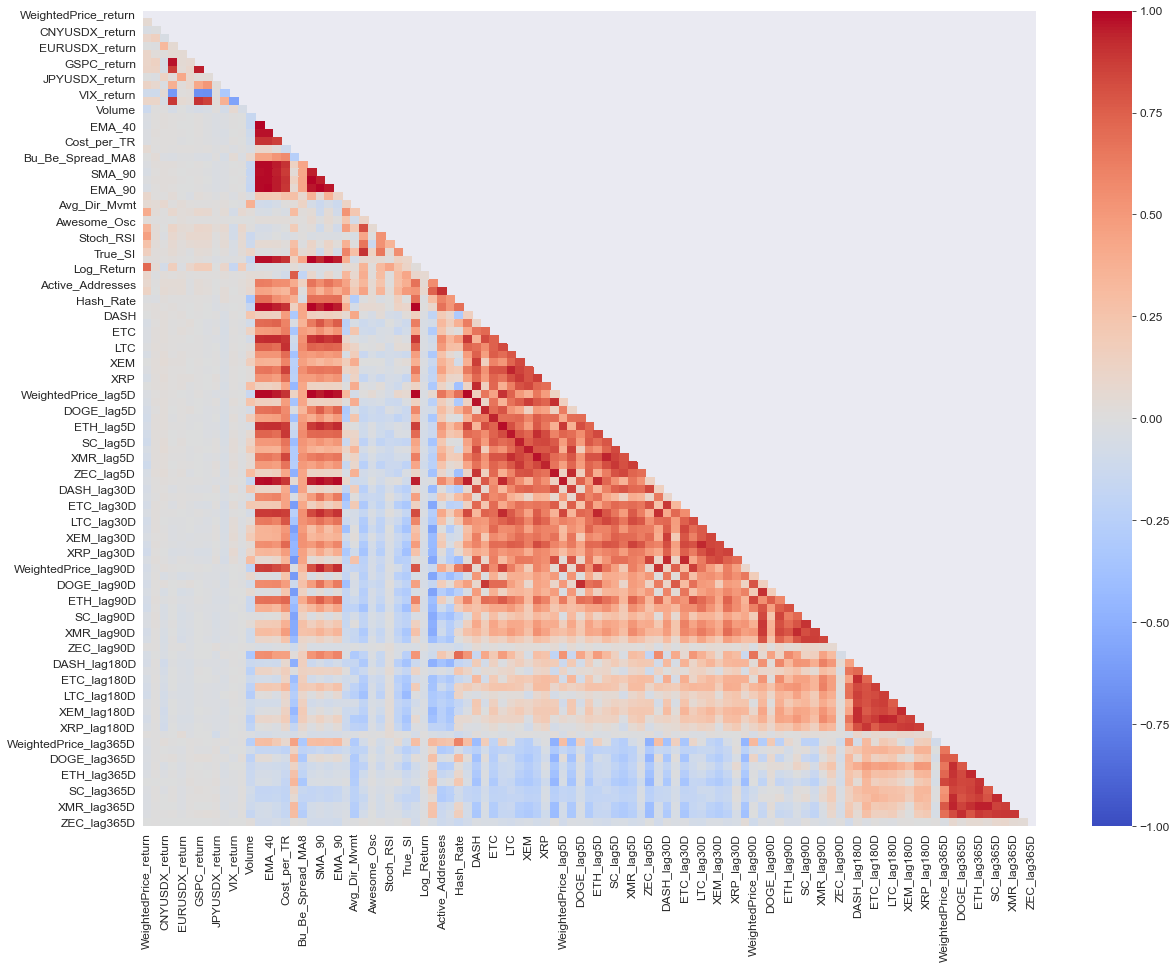

In [33]:
# Pearson Correlation Heatmap

corrmat_heat_lags = df_BTC_united_lags_no_ALT.corr()
fix, ax = plt.subplots(figsize=(20,15))
matrix = np.triu(corrmat_heat_lags)
_ax = sns.heatmap(corrmat_heat_lags, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask=matrix)
plt.show()

### Selecting Features - considering Multicollinearity

In [34]:
df_corr_lags = df_BTC_united_lags_no_ALT.drop(columns=['sentiment_elon', 
                                                       'sentiment_bitcoin', 
                                                       'WeightedPrice_return'])

In [35]:
corrmat_features_lags = df_corr_lags.corr()

In [36]:
columns_lags = np.full((corrmat_features_lags.shape[0], ), True, dtype=bool)

In [37]:
for i in range(corrmat_features_lags.shape[0]):
    for j in range(i+1, corrmat_features_lags.shape[0]):
        if abs(corrmat_features_lags.iloc[i, j]) >= 0.6:
            if columns_lags[j]:
                columns_lags[j] = False
selected_columns_lags = df_corr_lags.columns[columns_lags]
df_features_lags_new = df_corr_lags[selected_columns_lags]

In [38]:
list_selected_lags = list(selected_columns_lags)

In [39]:
add_col_lags = ['sentiment_elon', 'sentiment_bitcoin', 'WeightedPrice_return', 'WeightedPrice_lag365D']

In [40]:
list_col_final_lags = list_selected_lags + add_col_lags

In [41]:
list_col_final_lags.remove('Log_Return')

In [42]:
list_col_final_lags

['CLF_return',
 'CNYUSDX_return',
 'DJI_return',
 'EURUSDX_return',
 'GCF_return',
 'JPYUSDX_return',
 'TSLA_return',
 'Volume',
 'SMA_30',
 'Num_TR_per_Block',
 'Bu_Be_Spread_MA8',
 'MACD',
 'Avg_Dir_Mvmt',
 'RSI',
 'Awesome_Osc',
 'Stoch_RSI',
 'DASH',
 'ZEC_lag90D',
 'ZEC_lag180D',
 'ZEC_lag365D',
 'sentiment_elon',
 'sentiment_bitcoin',
 'WeightedPrice_return',
 'WeightedPrice_lag365D']

In [43]:
df_for_model_lags = df_BTC_united_lags_no_ALT[list_col_final_lags]

In [44]:
df_for_model_lags.head()

,CLF_return,CNYUSDX_return,DJI_return,EURUSDX_return,GCF_return,JPYUSDX_return,TSLA_return,Volume,SMA_30,Num_TR_per_Block,Bu_Be_Spread_MA8,MACD,Avg_Dir_Mvmt,RSI,Awesome_Osc,Stoch_RSI,DASH,ZEC_lag90D,ZEC_lag180D,ZEC_lag365D,sentiment_elon,sentiment_bitcoin,WeightedPrice_return,WeightedPrice_lag365D
Date,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9551.105487,836.549206,1826.866242,0.177500,55.472943,60.842605,81.220741,140.026661,0.594796,11.470403,277.419537,277.419537,277.419537,neutral,positive,0.032335,434.435131
2017-01-02,-0.025875,0.000216,0.006030,-0.004569,0.009043,-0.004521,0.015443,12317.029061,845.369632,1829.880503,0.183616,58.981924,62.132935,83.870837,148.760862,0.651973,11.904623,277.419537,277.419537,277.419537,neutral,positive,0.044238,430.755988
2017-01-03,0.000000,-0.000029,0.000000,-0.006360,0.000000,-0.005958,0.000000,12102.697127,854.045284,1839.410000,0.185655,62.402632,63.331099,85.063195,152.139388,0.658850,12.700470,277.419537,277.419537,277.419537,neutral,positive,-0.005809,433.545572
2017-01-04,0.017772,-0.002270,0.003038,-0.003835,0.002930,-0.001394,0.046085,30923.989588,865.701469,2143.920000,0.187693,72.515448,64.912753,89.924766,170.463439,0.991997,15.766139,277.419537,277.419537,277.419537,neutral,positive,0.078557,433.143672
2017-01-05,0.009388,0.005011,-0.002150,0.007771,0.013662,0.004662,-0.001057,54107.877473,874.552546,2060.721429,0.189732,69.485477,62.807267,62.628133,177.278107,0.000000,14.592710,277.419537,277.419537,277.419537,neutral,positive,-0.072940,431.201235


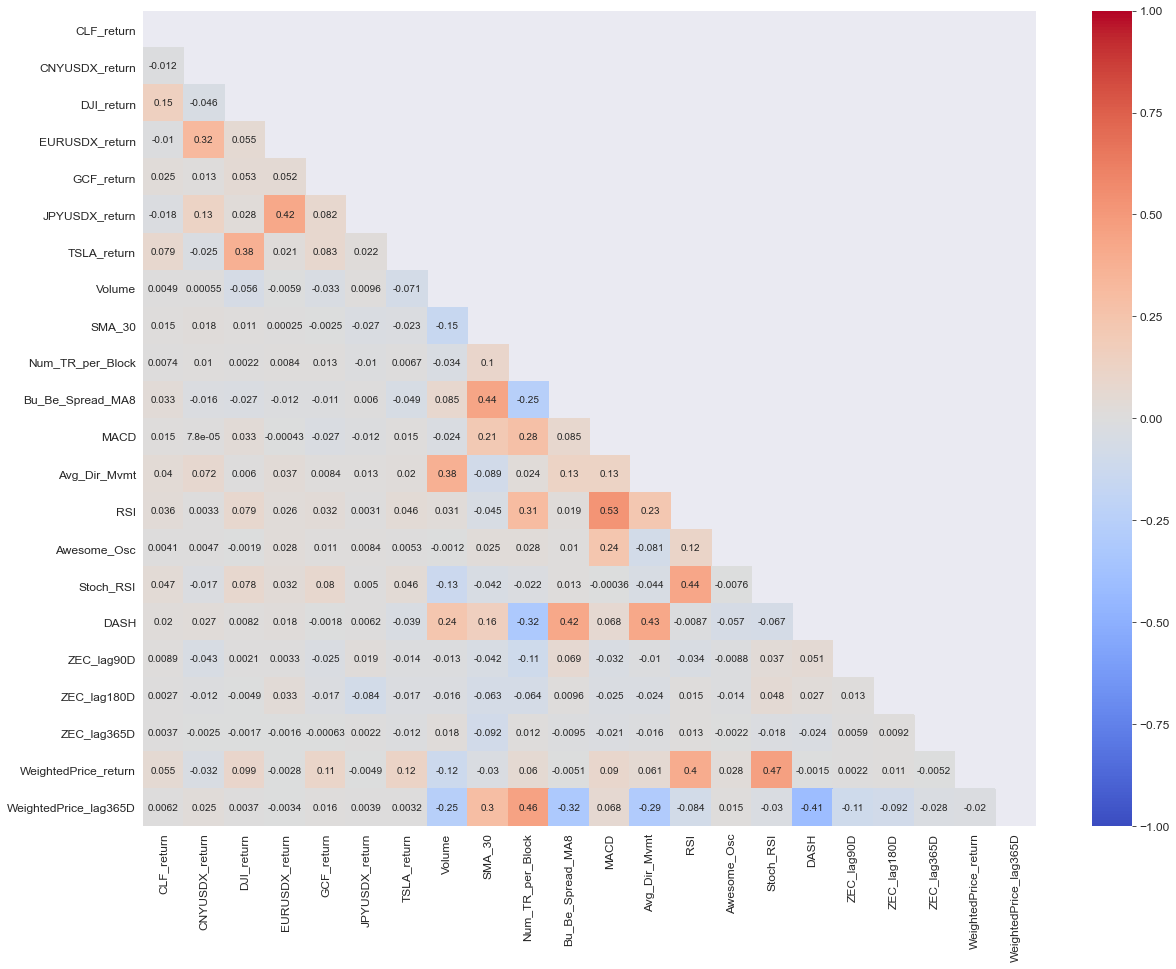

In [45]:
# Correlation Heatmap after Feature Selection

corrmat_new_lags = df_for_model_lags.corr()
fix, ax = plt.subplots(figsize=(20,15))
matrix = np.triu(corrmat_new_lags)
_ax = sns.heatmap(corrmat_new_lags, annot=True, fmt='.2g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask=matrix)
plt.show()

In [46]:
num_features_lags = corrmat_new_lags.columns

In [47]:
df_num_lags = df_BTC_united_lags_no_ALT[num_features_lags]

In [48]:
df_for_model_lags.shape

(1615, 24)

In [49]:
df_for_model_lags.isna().sum()

CLF_return               0
CNYUSDX_return           0
DJI_return               0
EURUSDX_return           0
GCF_return               0
JPYUSDX_return           0
TSLA_return              0
Volume                   0
SMA_30                   0
Num_TR_per_Block         0
Bu_Be_Spread_MA8         0
MACD                     0
Avg_Dir_Mvmt             0
RSI                      0
Awesome_Osc              0
Stoch_RSI                0
DASH                     0
ZEC_lag90D               0
ZEC_lag180D              0
ZEC_lag365D              0
sentiment_elon           0
sentiment_bitcoin        0
WeightedPrice_return     0
WeightedPrice_lag365D    0
dtype: int64

<a id='T'></a>
## <font color='darkblue'>__Train, Test Split and define Preprocessing Pipeline__</font>

In [50]:
X = df_for_model.drop('WeightedPrice_return', axis=1) 
y = df_for_model['WeightedPrice_return']

In [51]:
X.shape

(1615, 24)

In [52]:
y.shape

(1615,)

In [53]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1615 entries, 2017-01-01 to 2021-06-03
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DASH_return        1615 non-null   float64
 1   DOGE_return        1615 non-null   float64
 2   ETC_return         1615 non-null   float64
 3   SC_return          1615 non-null   float64
 4   XEM_return         1615 non-null   float64
 5   XRP_return         1615 non-null   float64
 6   CLF_return         1615 non-null   float64
 7   CNYUSDX_return     1615 non-null   float64
 8   DJI_return         1615 non-null   float64
 9   EURUSDX_return     1615 non-null   float64
 10  GCF_return         1615 non-null   float64
 11  JPYUSDX_return     1615 non-null   float64
 12  TSLA_return        1615 non-null   float64
 13  Volume             1615 non-null   float64
 14  SMA_30             1615 non-null   float64
 15  Num_TR_per_Block   1615 non-null   float64
 16  Bu_Be_Spread_M

In [54]:
# Simple 70-30% Splitting, no shuffling to respect the time series nature of the data
X_train = X[:int(X.shape[0]*0.7)]
X_test = X[int(X.shape[0]*0.7):]
y_train = y[:int(X.shape[0]*0.7)]
y_test = y[int(X.shape[0]*0.7):]

In [55]:
X_train.shape, y_train.shape

((1130, 24), (1130,))

In [56]:
X_test.shape, y_train.shape

((485, 24), (1130,))

### Build Pipeline: Column transformer

In [57]:
# Define numerical and categorical features
categorical_features = X.select_dtypes(include='object').columns
continuous_features = X.select_dtypes(exclude='object').columns
final_dataset_columns = X.columns.values

In [58]:
# Define Scaler and Column Transformer and a Prerocessor Pipeline 
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())])

categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    transformers = [("num", numeric_transformer, continuous_features),
                    ("cat", categorical_transformer, categorical_features)])

In [59]:
def set_pipeline(name, model):
    pipelined_model = Pipeline([("col_transformer", preprocessor), 
                         (name, model)])
    return pipelined_model

<a id='M'></a>
## <font color='darkblue'>__Initial Model Exploration__</font>

### Daily Returns

In [60]:
# Setup Models to evaluate

lr_regr = LinearRegression()
twd_regr = TweedieRegressor()
psa_regr = PassiveAggressiveRegressor()
sgd_regr = SGDRegressor()
ri_regr = Ridge()
br_regr = BayesianRidge()
ls_regr = Lasso(alpha=0.1)
ll_regr = LassoLars(alpha=0.1)
en_regr = ElasticNet(alpha=0.1)
knn_regr = KNeighborsRegressor()
dt_regr = DecisionTreeRegressor()
rf_regr = RandomForestRegressor()
xg_regr = xgb.XGBRegressor()

# List of the models as the input for the fitting loop
models = [
    ('LR', lr_regr),
    ('Tweedie', twd_regr),
    ('PassiveAggressive', psa_regr),
    ('SGD', sgd_regr),
    ('Ridge', ri_regr),
    ('BayesianRidge', br_regr),
    ('Lasso', ls_regr),
    ('LARSLasso', ll_regr),
    ('ElasticNet', en_regr),
    ('KNN regression', knn_regr),
    ('DecisionTree', dt_regr),
    ('RandomForest', rf_regr),
    ('XGBoost', xg_regr)
]

### Quick Evaluation based on the mainstream metrics

#### Performance Scores

In [61]:
pipelined_models = {} 
scores_init_train = {}
scores_init_test = {}
y_trs = {}
y_hats = {}

for name, model in models:
    pipelined_model = set_pipeline(name, model)
    pipelined_models[name] = {
        pipelined_model
    }
    
    # Model Training
    pipelined_model.fit(X_train, y_train)
        
    # Prediction on X_train
    y_tr = pipelined_model.predict(X_train)
    y_trs[name] = y_tr
    
    # Prediction on X_test
    y_hat = pipelined_model.predict(X_test)
    y_hats[name] = y_hat
    
    
    # Calculation of the Model Performance KPIs on the Training Set
    EVS_tr = (explained_variance_score(y_train, y_tr))
    ME_tr = (max_error(y_train, y_tr))
    MAE_tr = (mean_absolute_error(y_train, y_tr))
    MAPE_tr = (mean_absolute_percentage_error(y_train, y_tr))    
    MSE_tr = (mean_squared_error(y_train, y_tr))
    RMSE_tr = np.sqrt(mean_squared_error(y_train, y_tr))
    R2_tr = r2_score(y_train, y_tr)
    Adj_R2_tr = adjusted_r2_score(y_train, y_tr, X_train)

    scores_init_train[name] = {
                             'EVS_train': EVS_tr,
                             'ME_train': ME_tr,
                             'MAE_train': MAE_tr,
                             'MAPE_train': MAPE_tr,
                             'MSE_train': MSE_tr,
                             'RMSE_train': RMSE_tr,
                             'R2_train': R2_tr,
                             'Adj_R2_train': Adj_R2_tr
    }
    
    
    # Calculation of the Model Performance KPIs on the Test Set
    EVS = (explained_variance_score(y_test, y_hat))
    ME = (max_error(y_test, y_hat))
    MAE = (mean_absolute_error(y_test, y_hat))
    MAPE = (mean_absolute_percentage_error(y_test, y_hat))    
    MSE = (mean_squared_error(y_test, y_hat))
    RMSE = np.sqrt(mean_squared_error(y_test, y_hat))
    R2 = r2_score(y_test, y_hat)
    Adj_R2 = adjusted_r2_score(y_test, y_hat, X_test)

    scores_init_test[name] = {
                             'EVS_test': EVS,
                             'ME_test': ME,
                             'MAE_test': MAE,
                             'MAPE_test': MAPE,
                             'MSE_test': MSE,
                             'RMSE_test': RMSE,
                             'R2_test': R2,
                             'Adj_R2_test': Adj_R2
    }

In [62]:
df_scores_init_train = pd.DataFrame(scores_init_train).round(decimals=4).T
df_scores_init_train = df_scores_init_train[df_scores_init_train['Adj_R2_train']>0.4]

In [63]:
df_scores_init_test = pd.DataFrame(scores_init_test).round(decimals=4).T
df_scores_init_test = df_scores_init_test[df_scores_init_test['Adj_R2_test']>0]

In [64]:
df_scores_init_train.sort_values('Adj_R2_train', ascending=False)

,EVS_train,ME_train,MAE_train,MAPE_train,MSE_train,RMSE_train,R2_train,Adj_R2_train
DecisionTree,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000
XGBoost,0.9990,0.0070,0.0008,0.1632,0.0000,0.0011,0.9990,0.9990
RandomForest,0.9522,0.0559,0.0052,0.7062,0.0001,0.0078,0.9522,0.9512
KNN regression,0.6555,0.1501,0.0144,1.5011,0.0004,0.0210,0.6554,0.6479
LR,0.5556,0.1912,0.0169,2.4869,0.0006,0.0239,0.5556,0.5459
Ridge,0.5556,0.1912,0.0169,2.4866,0.0006,0.0239,0.5556,0.5459
BayesianRidge,0.5551,0.1909,0.0168,2.4545,0.0006,0.0239,0.5551,0.5455
SGD,0.5537,0.1896,0.0170,2.5268,0.0006,0.0239,0.5536,0.5439
Tweedie,0.5120,0.1894,0.0171,1.9323,0.0006,0.0250,0.5120,0.5014


In [65]:
df_scores_init_test.sort_values('Adj_R2_test', ascending=False)

,EVS_test,ME_test,MAE_test,MAPE_test,MSE_test,RMSE_test,R2_test,Adj_R2_test
RandomForest,0.7207,0.1029,0.0126,2.4042,0.0004,0.0187,0.7187,0.7040
XGBoost,0.6085,0.1070,0.0159,2.9775,0.0005,0.0223,0.6035,0.5828
Tweedie,0.5248,0.1178,0.0166,2.0515,0.0006,0.0244,0.5243,0.4995
KNN regression,0.4595,0.1209,0.0185,3.0401,0.0007,0.0261,0.4541,0.4257
BayesianRidge,0.3886,0.1500,0.0206,3.3437,0.0009,0.0292,0.3164,0.2807
SGD,0.3494,0.1593,0.0218,3.6243,0.0009,0.0308,0.2405,0.2009
Ridge,0.3336,0.1541,0.0217,3.6135,0.0010,0.0309,0.2350,0.1951
LR,0.3321,0.1543,0.0218,3.6217,0.0010,0.0310,0.2325,0.1924
DecisionTree,0.1460,0.1666,0.0221,4.0605,0.0011,0.0330,0.1297,0.0843


In [66]:
df_scores_init_train.columns = ['EVS', 'ME', 'MAE', 'MAPE', 'MSE',
                                'RMSE', 'R2', 'Adj_R2']

In [67]:
df_scores_init_test.columns = ['EVS', 'ME', 'MAE', 'MAPE', 'MSE',
                               'RMSE', 'R2', 'Adj_R2']

In [68]:
df_scores_init_train['traint'] = 'training'

In [69]:
df_scores_init_test['traint'] = 'initial test'

In [70]:
df_scores_init_merged =pd.concat([df_scores_init_train, df_scores_init_test])

In [71]:
df_scores_init_merged

,EVS,ME,MAE,MAPE,MSE,RMSE,R2,Adj_R2,traint
LR,0.5556,0.1912,0.0169,2.4869,0.0006,0.0239,0.5556,0.5459,training
Tweedie,0.5120,0.1894,0.0171,1.9323,0.0006,0.0250,0.5120,0.5014,training
SGD,0.5537,0.1896,0.0170,2.5268,0.0006,0.0239,0.5536,0.5439,training
Ridge,0.5556,0.1912,0.0169,2.4866,0.0006,0.0239,0.5556,0.5459,training
BayesianRidge,0.5551,0.1909,0.0168,2.4545,0.0006,0.0239,0.5551,0.5455,training
KNN regression,0.6555,0.1501,0.0144,1.5011,0.0004,0.0210,0.6554,0.6479,training
DecisionTree,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,training
RandomForest,0.9522,0.0559,0.0052,0.7062,0.0001,0.0078,0.9522,0.9512,training
XGBoost,0.9990,0.0070,0.0008,0.1632,0.0000,0.0011,0.9990,0.9990,training
LR,0.3321,0.1543,0.0218,3.6217,0.0010,0.0310,0.2325,0.1924,initial test


#### Initial Model Performance Chart

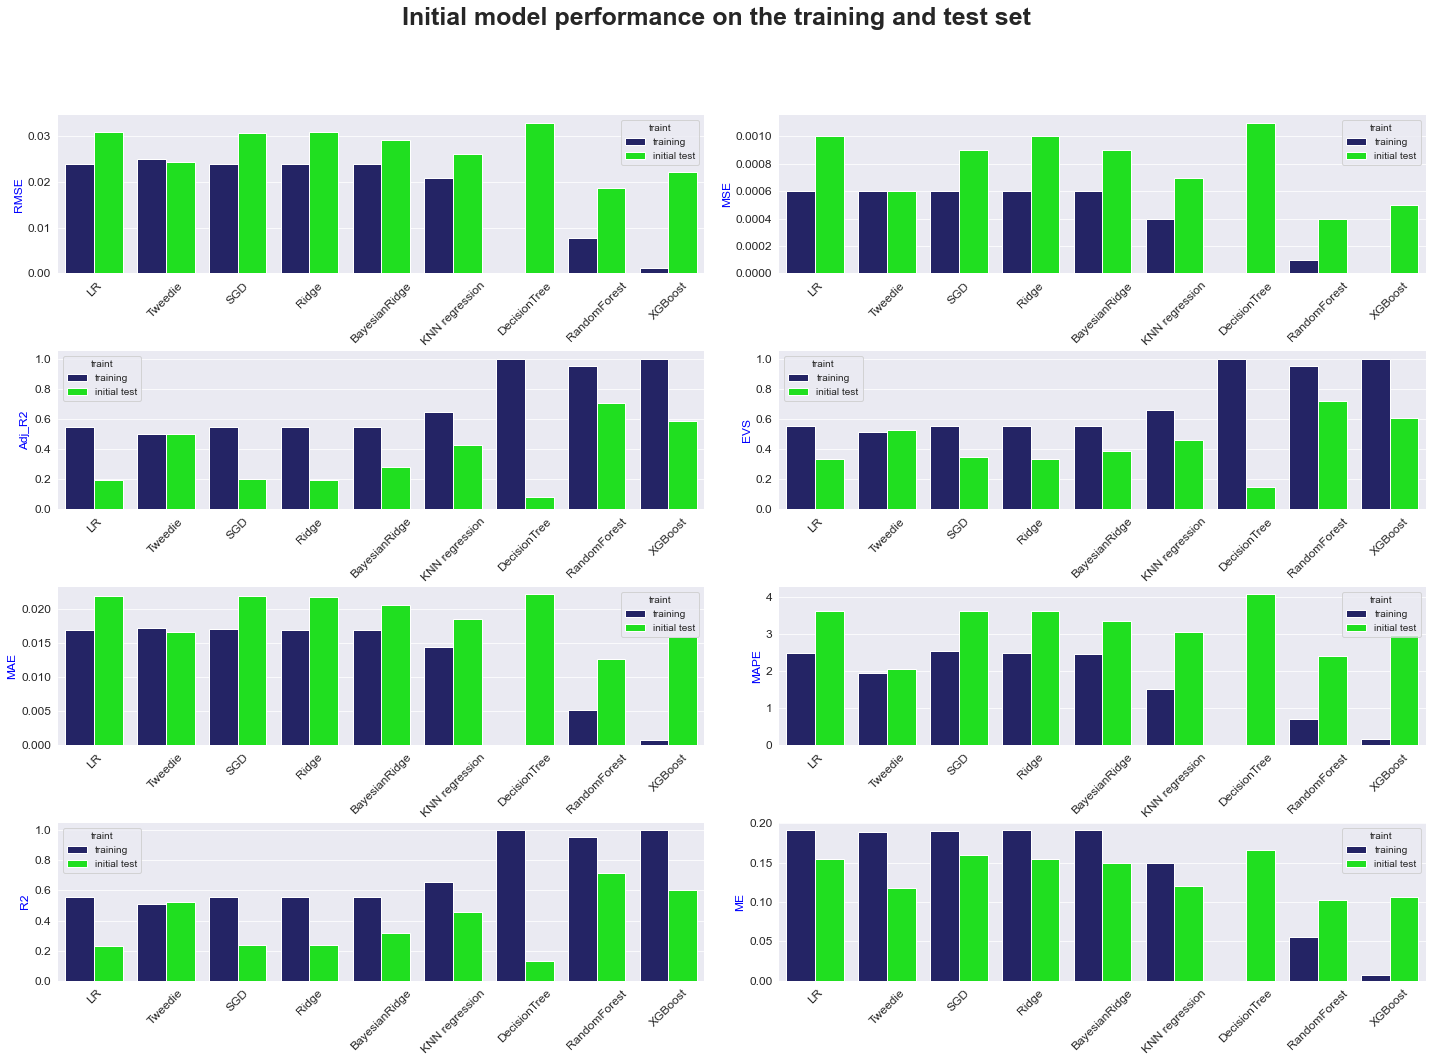

In [72]:
score_col = set(df_scores_init_merged.columns) - set(['traint'])

fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(20,15))
for feat_num, feat_name in enumerate(score_col):
    sns.barplot(data=df_scores_init_merged, x=df_scores_init_merged.index, y=df_scores_init_merged[feat_name],
                hue='traint', ax=axs[int(feat_num/2), feat_num%2], palette=['midnightblue', 'lime'])
    sns.despine(left=True)
for ax, dat in zip(axs.ravel(), df_scores_init_merged):
    ax.tick_params(axis='x', labelrotation=45)
plt.tight_layout()
plt.suptitle("Initial model performance on the training and test set", fontsize = 25, fontweight = 'bold')
fig.subplots_adjust(top=0.88)
plt.show()

<a id='C'></a>
## <font color='darkblue'>__Cross-Validation__</font>

In [73]:
# We make a fresh set of training and test set and we set aside the test to be untouched
X_inter, X_test_new, y_inter, y_test_new = train_test_split(X, y, test_size = 0.3, shuffle = False, stratify =None)

### Train, Validation and Test Split using TimeSeries Split

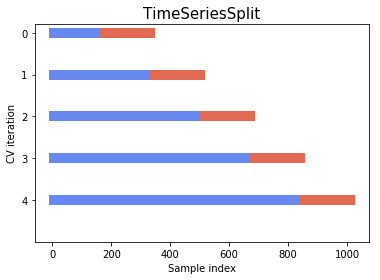

In [74]:
from IPython.display import Image
Image(filename=data_path+'\\07_img\\TimeSeries-Split.png')

In [75]:
# Instantiating a Time-Series Split instance instead of random shuffling, we use a Forward-Walk CV
tscv = TimeSeriesSplit(n_splits=5)

In [76]:
train_test_split = tscv.split(X_inter)

for train, test in train_test_split:
    X_train_cv, y_train_cv = X.iloc[train], y.iloc[train]
    X_test_cv, y_test_cv = X.iloc[test], y.iloc[test]
    
    test_length = len(X_test_cv)
    train_cv_split = [(list(range(train[0],train[-test_length])),
                       list(range(train[-test_length],train[-1]+1)))]
    
    print("Training:" , X_train_cv.index[0], "--", X_train_cv.index[-test_length-1],
          ", Cv:"     , X_train_cv.index[-test_length], "--", X_train_cv.index[-1],
          ", Test:"   , X_test_cv.index[0], "--", X_test_cv.index[-1])

Training: 2017-01-01 -- 2017-01-02 , Cv: 2017-01-03 -- 2017-07-09 , Test: 2017-07-10 -- 2018-01-13
Training: 2017-01-01 -- 2017-07-09 , Cv: 2017-07-10 -- 2018-01-13 , Test: 2018-01-14 -- 2018-07-20
Training: 2017-01-01 -- 2018-01-13 , Cv: 2018-01-14 -- 2018-07-20 , Test: 2018-07-21 -- 2019-01-24
Training: 2017-01-01 -- 2018-07-20 , Cv: 2018-07-21 -- 2019-01-24 , Test: 2019-01-25 -- 2019-07-31
Training: 2017-01-01 -- 2019-01-24 , Cv: 2019-01-25 -- 2019-07-31 , Test: 2019-08-01 -- 2020-02-04


[None, None, None, None]

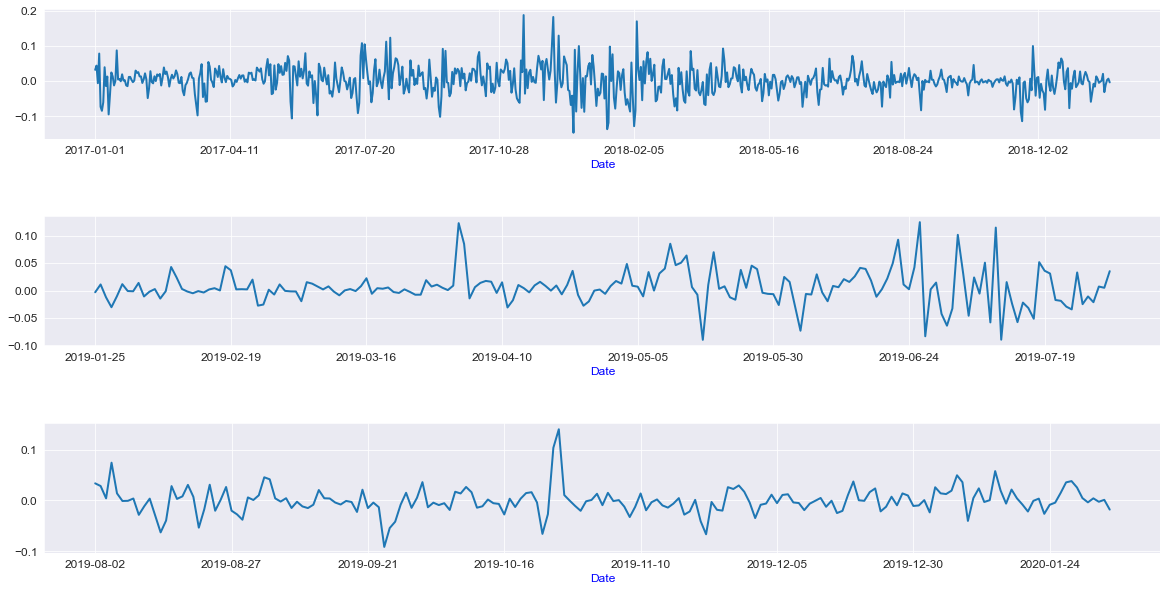

In [77]:
# Plot Training & Test set of Target variable -> TimeSeries Split last Set
years = mdates.YearLocator()    # only print label for the years
months = mdates.MonthLocator()  # mark months as ticks
years_fmt = mdates.DateFormatter('%Y-%b')
fmt = mdates.DateFormatter('%b')

fig, axs = plt.subplots(nrows=3,ncols=1, figsize=(20, 10))

_ax1 = y_train_cv[y_train_cv.index<=X_train_cv.index[-test_length-1]].plot(ax=axs[0])
_ax2 = y_train_cv[(y_train_cv.index>X_train_cv.index[-test_length-1]) & (y_train_cv.index<=X_train_cv.index[-1])].plot(ax=axs[1])
_ax2 = y_test_cv[(y_test_cv.index>X_test_cv.index[0]) & (y_test_cv.index<=X_test_cv.index[-1])].plot(ax=axs[2])
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(fmt)
plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

### Cross Validation with TimeSeries Split

In [78]:
model_names = []
score_names = []
scores = []
scores_means = []

tscv_scoring = ['r2', 'explained_variance', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error']

for name, model in models:
    pipelined_model = set_pipeline(name, model)
   
    # Cross Val Scores
    for score in tscv_scoring:
        tscv_score = cross_val_score(pipelined_model, X_train_cv, y_train_cv,
                                        scoring=score, cv=tscv)
        model_names.append(name)
        score_names.append(score)
        if score in ('r2', 'explained_variance'):
            scores.append(tscv_score)
            scores_means.append(np.mean(tscv_score))
        else:
            scores.append(-tscv_score)
            scores_means.append(np.mean(-tscv_score))

In [79]:
df_tscv = pd.DataFrame(score_names, 
                       columns=['metric']).merge(pd.DataFrame(scores_means, 
                                                              columns=['score']), 
                                                              left_index=True, right_index=True).merge(pd.DataFrame(model_names, 
                                                                                                                    columns=['model']), 
                                                                                                                    left_index=True, 
                                                                                                                    right_index=True)

In [80]:
df_scores_tscv = df_tscv.pivot_table('score', ['model'], 'metric')

In [81]:
df_scores_tscv.rename(columns={'explained_variance': 'EVS', 'neg_mean_absolute_error': 'MAE', 
                               'neg_mean_squared_error': 'MSE', 'neg_root_mean_squared_error': 'RMSE', 'r2': 'R2'}, inplace=True)

In [82]:
df_scores_tscv.sort_values(by='R2', ascending=False)

metric,EVS,MAE,MSE,RMSE,R2
model,,,,,
RandomForest,0.656995,0.016491,0.000568,0.021971,0.650014
Tweedie,0.505442,0.020480,0.000866,0.027075,0.474244
XGBoost,0.492481,0.021315,0.000909,0.027561,0.463224
KNN regression,0.368082,0.021828,0.001027,0.029825,0.347407
SGD,0.392053,0.026243,0.001362,0.032284,0.188863
PassiveAggressive,0.201360,0.025683,0.001274,0.033219,0.183216
DecisionTree,0.128997,0.028141,0.001536,0.035965,0.085016
ElasticNet,0.000000,0.027181,0.001486,0.036934,-0.030223
LARSLasso,0.000000,0.027181,0.001486,0.036934,-0.030223


### Train, Validation and Test Split using Blocked Cross Validation

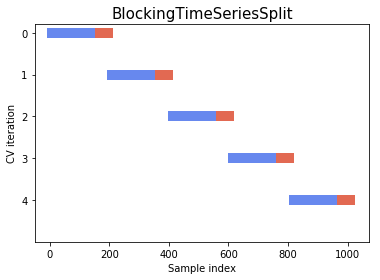

In [83]:
from IPython.display import Image
Image(filename=data_path+'\\07_img\\Blocking-Time-Series-Split.png')

In [84]:
# Define class for Blocking Time Series Split
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

(Ref: PacktHub, Cross-Validation strategies for Time Series forecasting, https://hub.packtpub.com/cross-validation-strategies-for-time-series-forecasting-tutorial/)

In [85]:
# Instantiating a Blocking Time Series Split instance
btscv = BlockingTimeSeriesSplit(n_splits=5)

In [86]:
train_test_split_b = btscv.split(X_inter)

for train_b, test_b in train_test_split_b:
    X_train_bcv, y_train_bcv = X.iloc[train_b], y.iloc[train_b]
    X_test_bcv, y_test_bcv = X.iloc[test_b], y.iloc[test_b]
    
    test_length_bcv = len(X_test_bcv)
    train_bcv_split = [(list(range(train_b[0],train_b[-test_length_bcv])),
                        list(range(train_b[-test_length_bcv],train_b[-1]+1)))]
    
    print("Training:"  , X_train_bcv.index[0], "--", X_train_bcv.index[-test_length_bcv-1],
          ", Cv:"     , X_train_bcv.index[-test_length_bcv], "--", X_train_bcv.index[-1],
          ", Test:"   , X_test_bcv.index[0], "--", X_test_bcv.index[-1])

Training: 2017-01-01 -- 2017-05-14 , Cv: 2017-05-15 -- 2017-06-29 , Test: 2017-06-30 -- 2017-08-14
Training: 2017-08-15 -- 2017-12-26 , Cv: 2017-12-27 -- 2018-02-10 , Test: 2018-02-11 -- 2018-03-28
Training: 2018-03-29 -- 2018-08-09 , Cv: 2018-08-10 -- 2018-09-24 , Test: 2018-09-25 -- 2018-11-09
Training: 2018-11-10 -- 2019-03-23 , Cv: 2019-03-24 -- 2019-05-08 , Test: 2019-05-09 -- 2019-06-23
Training: 2019-06-24 -- 2019-11-04 , Cv: 2019-11-05 -- 2019-12-20 , Test: 2019-12-21 -- 2020-02-04


[None, None, None, None]

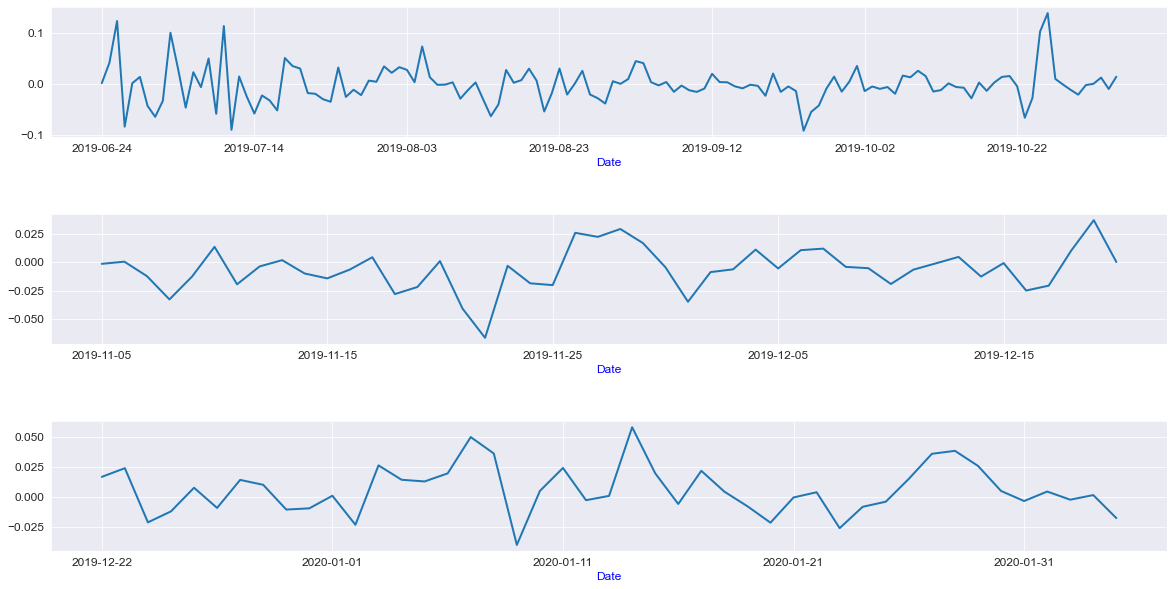

In [87]:
# Plot Training & Test set of Target variable -> Blocking Time Series Split
years = mdates.YearLocator()    # only print label for the years
months = mdates.MonthLocator()  # mark months as ticks
years_fmt = mdates.DateFormatter('%Y-%b')
fmt = mdates.DateFormatter('%b')

fig, axs = plt.subplots(nrows=3,ncols=1, figsize=(20, 10))

_ax1 = y_train_bcv[y_train_bcv.index<=X_train_bcv.index[-test_length_bcv-1]].plot(ax=axs[0])
_ax2 = y_train_bcv[(y_train_bcv.index>X_train_bcv.index[-test_length_bcv-1]) & (y_train_bcv.index<=X_train_bcv.index[-1])].plot(ax=axs[1])
_ax2 = y_test_bcv[(y_test_bcv.index>X_test_bcv.index[0]) & (y_test_bcv.index<=X_test_bcv.index[-1])].plot(ax=axs[2])
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(fmt)
plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

### Cross Validation with Blocking Time Series Split

In [88]:
model_names_b = []
score_names_b = []
scores_b = []
scores_means_b = []

btscv_scoring = ['r2', 'explained_variance', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error']

for name, model in models:
    pipelined_model = set_pipeline(name, model)
   
    # Cross Val Scores
    for score in btscv_scoring:
        btscv_score = cross_val_score(pipelined_model, X_train_bcv, y_train_bcv,
                                        scoring=score, cv=btscv)
        model_names_b.append(name)
        score_names_b.append(score)
        if score in ('r2', 'explained_variance'):
            scores_b.append(btscv_score)
            scores_means_b.append(np.mean(btscv_score))
        else:
            scores_b.append(-btscv_score)
            scores_means_b.append(np.mean(-btscv_score))

In [89]:
df_btscv = pd.DataFrame(score_names_b, 
                        columns=['metric']).merge(pd.DataFrame(scores_means_b, 
                                                               columns=['score']), 
                                                               left_index=True, 
                                                               right_index=True).merge(pd.DataFrame(model_names_b, 
                                                                                                    columns=['model']), 
                                                                                                    left_index=True, 
                                                                                                    right_index=True)

In [90]:
df_scores_btscv = df_btscv.pivot_table('score', ['model'], 'metric')

In [91]:
df_scores_btscv.rename(columns={'explained_variance': 'EVS', 'neg_mean_absolute_error': 'MAE', 
                               'neg_mean_squared_error': 'MSE', 'neg_root_mean_squared_error': 'RMSE', 'r2': 'R2'}, inplace=True)

In [92]:
df_scores_btscv.sort_values(by='R2', ascending=False)

metric,EVS,MAE,MSE,RMSE,R2
model,,,,,
RandomForest,5.961767e-01,0.009568,0.000155,0.011913,0.557518
Tweedie,5.856395e-01,0.011257,0.000200,0.013820,0.382265
XGBoost,2.276295e-01,0.012817,0.000273,0.016100,0.137318
SGD,5.810622e-01,0.012318,0.000272,0.014642,0.137207
KNN regression,3.273849e-01,0.013224,0.000281,0.016700,0.119203
DecisionTree,9.244972e-04,0.014855,0.000387,0.017826,0.062992
PassiveAggressive,6.910616e-02,0.015950,0.000405,0.019116,-0.005595
ElasticNet,4.440892e-17,0.018110,0.000489,0.021723,-0.379282
LARSLasso,4.440892e-17,0.018110,0.000489,0.021723,-0.379282


### Model screening for fine-tuning

In [93]:
df_init_to_append = df_scores_init_merged.drop(columns=['ME', 'MAPE', 'Adj_R2'])

In [94]:
df_scores_tscv['traint'] = 'crossval_tscv'

In [95]:
df_scores_btscv['traint'] = 'crossval_btscv'

In [96]:
df_final_scores = pd.concat([df_init_to_append, df_scores_tscv, df_scores_btscv])

In [97]:
df_train_test_cv_scores = df_final_scores[df_final_scores['R2']>0].drop(['LR', 'Ridge'], axis=0)

In [98]:
df_train_test_cv_scores

,EVS,MAE,MSE,RMSE,R2,traint
Tweedie,0.512000,0.017100,0.000600,0.025000,0.512000,training
SGD,0.553700,0.017000,0.000600,0.023900,0.553600,training
BayesianRidge,0.555100,0.016800,0.000600,0.023900,0.555100,training
KNN regression,0.655500,0.014400,0.000400,0.021000,0.655400,training
DecisionTree,1.000000,0.000000,0.000000,0.000000,1.000000,training
RandomForest,0.952200,0.005200,0.000100,0.007800,0.952200,training
XGBoost,0.999000,0.000800,0.000000,0.001100,0.999000,training
Tweedie,0.524800,0.016600,0.000600,0.024400,0.524300,initial test
SGD,0.349400,0.021800,0.000900,0.030800,0.240500,initial test
BayesianRidge,0.388600,0.020600,0.000900,0.029200,0.316400,initial test


#### Cross-Validated Model Performance Chart

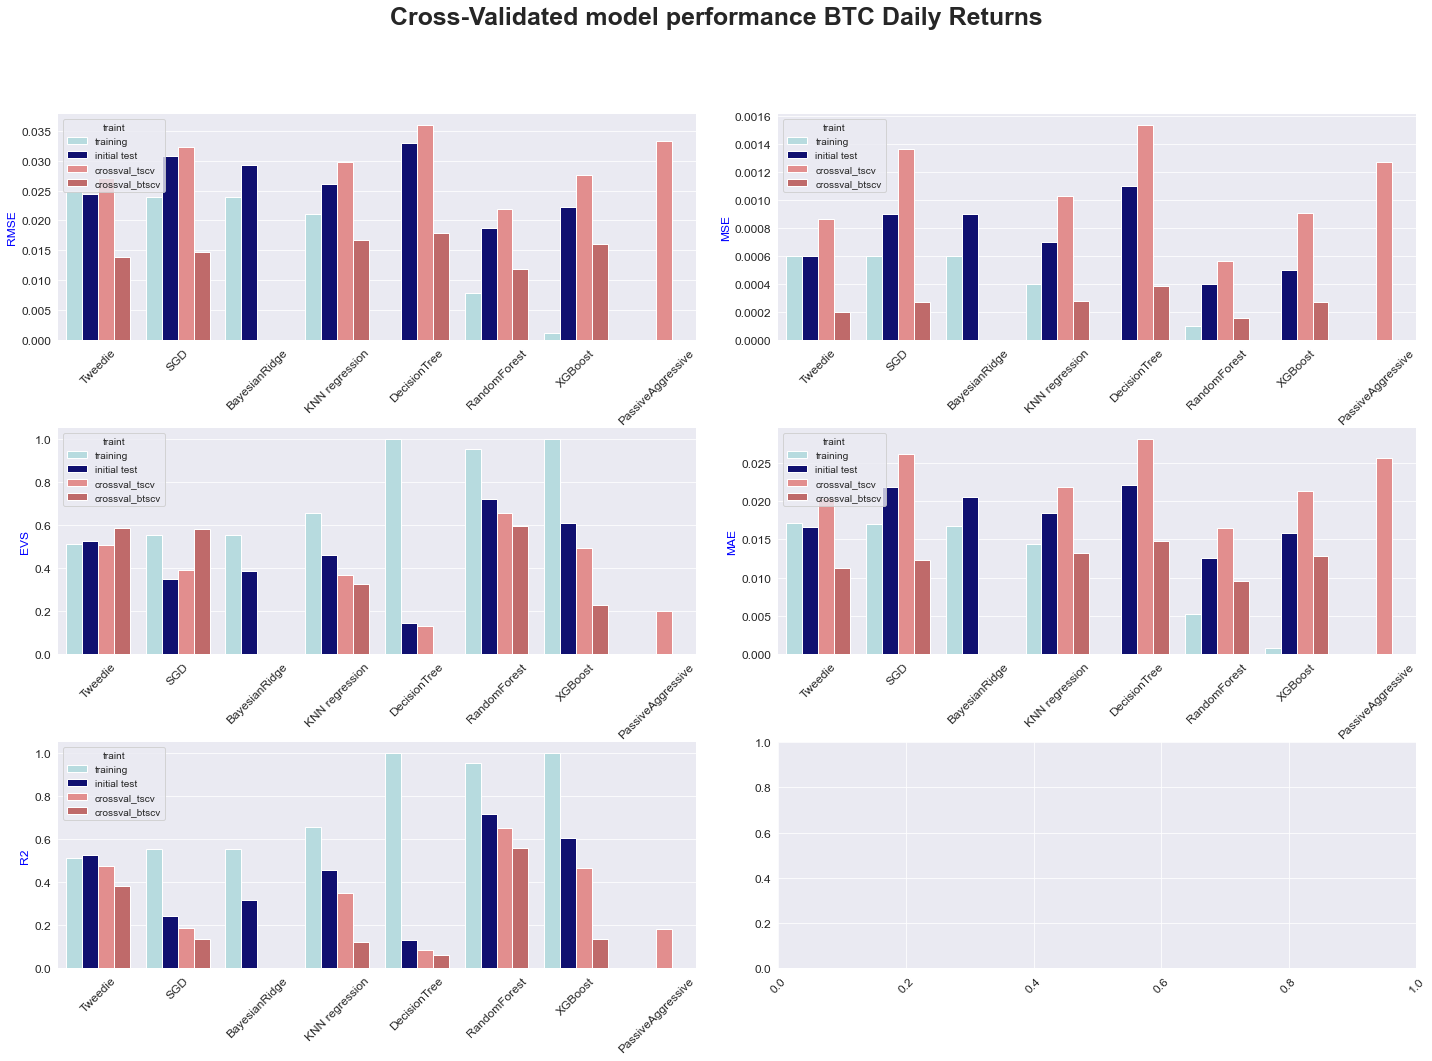

In [99]:
cv_score_col = set(df_train_test_cv_scores.columns) - set(['traint'])

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20,15))
for feat_num, feat_name in enumerate(cv_score_col):
    sns.barplot(data=df_train_test_cv_scores, x=df_train_test_cv_scores.index, y=df_train_test_cv_scores[feat_name],
                hue='traint', ax=axs[int(feat_num/2), feat_num%2], palette=['powderblue', 'navy', 'lightcoral', 'indianred'])
    sns.despine(left=True)
for ax, dat in zip(axs.ravel(), df_train_test_cv_scores):
    ax.tick_params(axis='x', labelrotation=45)
plt.tight_layout()
plt.suptitle("Cross-Validated model performance BTC Daily Returns", fontsize = 25, fontweight = 'bold')
fig.subplots_adjust(top=0.88)
plt.show()

<a id='H'></a>
## <font color='darkblue'>__Hyperparameter Tuning__</font>

### Extract Initial Parameters

In [100]:
# Get the initial parameters for the base models
initial_params = {
    'Tweedie Regressor': twd_regr.get_params(),
    'SGD Regressor': sgd_regr.get_params(),
    'KNN Regressor': knn_regr.get_params(),
    'Random Forest Regressor': rf_regr.get_params(),
    'XG Boost Regressor': xg_regr.get_params()
 }

### Grid Search

### Tweedie Regressor

In [101]:
initial_params['Tweedie Regressor']

{'alpha': 1.0,
 'fit_intercept': True,
 'link': 'auto',
 'max_iter': 100,
 'power': 0.0,
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [102]:
pipe_twd = Pipeline([("col_transformer", preprocessor), 
                    ('regressor', TweedieRegressor())])

#### Run Cross-Validation with Grid Search

In [103]:
# Setup parameters

alpha = [0.01, 0.02, 0.03, 0.05, 1.0, 2.0, 3.0, 5.0]
fit_intercept = [True]
link = ['auto']
max_iter = [50000]
power = [0.0, 1.0, 2.0, 3.0]
tol = [0.0001]
warm_start = [False]
col_transformer = [preprocessor]

# Hyperparameter Optimization
twd_grid_search = {'col_transformer': col_transformer,
                    'regressor__power': power, 
                    'regressor__alpha': alpha, 
                    'regressor__fit_intercept': fit_intercept, 
                    'regressor__link': link,
                    'regressor__max_iter': max_iter,
                    'regressor__tol': tol,
                    'regressor__warm_start': warm_start,
                    }


# Run Grid Serch
scores_grid_twd = cross_val_score(GridSearchCV(estimator=pipe_twd,
                                                  param_grid=twd_grid_search,
                                                  cv=btscv,
                                                  scoring='r2',
                                                  verbose = 0,
                                                  n_jobs = -1), X_train_bcv, y_train_bcv, cv=btscv)
                         
print("TWD Cross-validation scores (R2): ", scores_grid_twd)
print("TWD Mean cross-validation score (R2): ", scores_grid_twd.mean())

TWD Cross-validation scores (R2):  [-8.19820932e+00 -8.07414766e-03 -2.40457335e+00 -1.77194395e+00
 -2.39234766e-01]
TWD Mean cross-validation score (R2):  -2.5244071069737597


#### Run Grid Search & Select Best Estimator

In [104]:
# Run Tweedie Grid Serch Fit
clf_twd_grid = GridSearchCV(estimator=pipe_twd,
                            param_grid=twd_grid_search,
                            cv=tscv,
                            scoring='r2',
                            verbose = 3,
                            n_jobs = -1)                         

search_twd_grid = clf_twd_grid.fit(X_train_cv, y_train_cv)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [105]:
pd.set_option('max_colwidth', None)
results_twd = pd.DataFrame(search_twd_grid.cv_results_)
results_twd = results_twd[['params', 'rank_test_score', 'mean_test_score', 'std_test_score', 
                           'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']].sort_values(by=['rank_test_score'])
results_twd[results_twd['rank_test_score']<=3]

,params,rank_test_score,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
16,"{'col_transformer': ColumnTransformer(transformers=[('num', Pipeline(steps=[('scaler', StandardScaler())]), Index(['DASH_return', 'DOGE_return', 'ETC_return', 'SC_return', 'XEM_return', 'XRP_return', 'CLF_return', 'CNYUSDX_return', 'DJI_return', 'EURUSDX_return', 'GCF_return', 'JPYUSDX_return', 'TSLA_return', 'Volume', 'SMA_30', 'Num_TR_per_Block', 'Bu_Be_Spread_MA8', 'MACD', 'Avg_Dir_Mvmt', 'RSI', 'Awesome_Osc', 'Stoch_RSI'], dtype='object')), ('cat', Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]), Index(['sentiment_elon', 'sentiment_bitcoin'], dtype='object'))]), 'regressor__alpha': 1.0, 'regressor__fit_intercept': True, 'regressor__link': 'auto', 'regressor__max_iter': 50000, 'regressor__power': 0.0, 'regressor__tol': 0.0001, 'regressor__warm_start': False}",1,0.474244,0.170279,0.217895,0.372803,0.642850,0.675247,0.462424
20,"{'col_transformer': ColumnTransformer(transformers=[('num', Pipeline(steps=[('scaler', StandardScaler())]), Index(['DASH_return', 'DOGE_return', 'ETC_return', 'SC_return', 'XEM_return', 'XRP_return', 'CLF_return', 'CNYUSDX_return', 'DJI_return', 'EURUSDX_return', 'GCF_return', 'JPYUSDX_return', 'TSLA_return', 'Volume', 'SMA_30', 'Num_TR_per_Block', 'Bu_Be_Spread_MA8', 'MACD', 'Avg_Dir_Mvmt', 'RSI', 'Awesome_Osc', 'Stoch_RSI'], dtype='object')), ('cat', Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]), Index(['sentiment_elon', 'sentiment_bitcoin'], dtype='object'))]), 'regressor__alpha': 2.0, 'regressor__fit_intercept': True, 'regressor__link': 'auto', 'regressor__max_iter': 50000, 'regressor__power': 0.0, 'regressor__tol': 0.0001, 'regressor__warm_start': False}",2,0.435450,0.155370,0.205485,0.346306,0.611532,0.603492,0.410432
24,"{'col_transformer': ColumnTransformer(transformers=[('num', Pipeline(steps=[('scaler', StandardScaler())]), Index(['DASH_return', 'DOGE_return', 'ETC_return', 'SC_return', 'XEM_return', 'XRP_return', 'CLF_return', 'CNYUSDX_return', 'DJI_return', 'EURUSDX_return', 'GCF_return', 'JPYUSDX_return', 'TSLA_return', 'Volume', 'SMA_30', 'Num_TR_per_Block', 'Bu_Be_Spread_MA8', 'MACD', 'Avg_Dir_Mvmt', 'RSI', 'Awesome_Osc', 'Stoch_RSI'], dtype='object')), ('cat', Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]), Index(['sentiment_elon', 'sentiment_bitcoin'], dtype='object'))]), 'regressor__alpha': 3.0, 'regressor__fit_intercept': True, 'regressor__link': 'auto', 'regressor__max_iter': 50000, 'regressor__power': 0.0, 'regressor__tol': 0.0001, 'regressor__warm_start': False}",3,0.387108,0.143382,0.171701,0.310242,0.557514,0.531763,0.364318


In [106]:
best_model_twd = search_twd_grid.best_estimator_['regressor']

In [107]:
best_model_twd

TweedieRegressor(max_iter=50000)

### SGD Regressor

In [108]:
initial_params['SGD Regressor']

{'alpha': 0.0001,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_loss',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'penalty': 'l2',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [109]:
pipe_sgd = Pipeline([("col_transformer", preprocessor), 
                    ('regressor', SGDRegressor())])

#### Run Cross-Validation with Grid Search

In [110]:
# Setup parameters
alpha = [0.0001]
average = [False]
early_stopping = [False]
epsilon = [0.1, 0.15, 0.2]
eta0 = [0.01]
fit_intercept = [True]
l1_ratio = [0.15]
learning_rate = ['invscaling']
loss = ['squared_loss']
max_iter = [100000]
n_iter_no_change = [5]
penalty = ['l2']
power_t =  [0.25, 0.3, 0.5]
random_state = [None]
shuffle = [False]
tol = [0.001]
validation_fraction = [0.1, 0.2, 0.3]
warm_start = [False, True]
col_transformer = [preprocessor]

# Hyperparameter Optimization
sgd_grid_search = {'col_transformer': col_transformer,
                    'regressor__average': average,
                    'regressor__early_stopping': early_stopping,
                    'regressor__epsilon': epsilon, 
                    'regressor__eta0': eta0, 
                    'regressor__fit_intercept': fit_intercept, 
                    'regressor__l1_ratio': l1_ratio, 
                    'regressor__learning_rate': learning_rate,
                    'regressor__loss': loss,
                    'regressor__max_iter': max_iter,
                    'regressor__n_iter_no_change': n_iter_no_change, 
                    'regressor__penalty': penalty, 
                    'regressor__power_t': power_t,
                    'regressor__random_state': random_state,
                    'regressor__shuffle': shuffle,
                    'regressor__tol': tol,
                    'regressor__validation_fraction': validation_fraction,
                    'regressor__warm_start': warm_start
                    }


# Run Grid Serch
scores_grid_sgd = cross_val_score(GridSearchCV(estimator=pipe_sgd,
                                                  param_grid=sgd_grid_search,
                                                  cv=tscv,
                                                  scoring='r2',
                                                  verbose = 0,
                                                  n_jobs = -1), X_train_cv, y_train_cv, cv=tscv)
                         
print("SGD Cross-validation scores (R2): ", scores_grid_sgd)
print("SGD Mean cross-validation score (R2): ", scores_grid_sgd.mean())

SGD Cross-validation scores (R2):  [0.28030601 0.42877195 0.60797265 0.71338644 0.50861449]
SGD Mean cross-validation score (R2):  0.5078103067342038


#### Run Grid Search & Select Best Estimator

In [111]:
# Run Grid Search Fit
clf_sgd_grid = GridSearchCV(estimator=pipe_sgd,
                            param_grid=sgd_grid_search,
                            cv=tscv,
                            scoring='r2',
                            verbose = 0,
                            n_jobs = -1)                         

search_sgd_grid = clf_sgd_grid.fit(X_train_cv, y_train_cv)

In [112]:
pd.set_option('max_colwidth', None)
results_sgd = pd.DataFrame(search_sgd_grid.cv_results_)
results_sgd = results_sgd[['params', 'rank_test_score', 'mean_test_score', 'std_test_score', 
                           'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']].sort_values(by=['rank_test_score'])
results_sgd[results_sgd['rank_test_score']<=3]

,params,rank_test_score,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
53,"{'col_transformer': ColumnTransformer(transformers=[('num', Pipeline(steps=[('scaler', StandardScaler())]), Index(['DASH_return', 'DOGE_return', 'ETC_return', 'SC_return', 'XEM_return', 'XRP_return', 'CLF_return', 'CNYUSDX_return', 'DJI_return', 'EURUSDX_return', 'GCF_return', 'JPYUSDX_return', 'TSLA_return', 'Volume', 'SMA_30', 'Num_TR_per_Block', 'Bu_Be_Spread_MA8', 'MACD', 'Avg_Dir_Mvmt', 'RSI', 'Awesome_Osc', 'Stoch_RSI'], dtype='object')), ('cat', Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]), Index(['sentiment_elon', 'sentiment_bitcoin'], dtype='object'))]), 'regressor__average': False, 'regressor__early_stopping': False, 'regressor__epsilon': 0.2, 'regressor__eta0': 0.01, 'regressor__fit_intercept': True, 'regressor__l1_ratio': 0.15, 'regressor__learning_rate': 'invscaling', 'regressor__loss': 'squared_loss', 'regressor__max_iter': 100000, 'regressor__n_iter_no_change': 5, 'regressor__penalty': 'l2', 'regressor__power_t': 0.5, 'regressor__random_state': None, 'regressor__shuffle': False, 'regressor__tol': 0.001, 'regressor__validation_fraction': 0.3, 'regressor__warm_start': True}",1,0.50781,0.148526,0.280306,0.428772,0.607973,0.713386,0.508614
30,"{'col_transformer': ColumnTransformer(transformers=[('num', Pipeline(steps=[('scaler', StandardScaler())]), Index(['DASH_return', 'DOGE_return', 'ETC_return', 'SC_return', 'XEM_return', 'XRP_return', 'CLF_return', 'CNYUSDX_return', 'DJI_return', 'EURUSDX_return', 'GCF_return', 'JPYUSDX_return', 'TSLA_return', 'Volume', 'SMA_30', 'Num_TR_per_Block', 'Bu_Be_Spread_MA8', 'MACD', 'Avg_Dir_Mvmt', 'RSI', 'Awesome_Osc', 'Stoch_RSI'], dtype='object')), ('cat', Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]), Index(['sentiment_elon', 'sentiment_bitcoin'], dtype='object'))]), 'regressor__average': False, 'regressor__early_stopping': False, 'regressor__epsilon': 0.15, 'regressor__eta0': 0.01, 'regressor__fit_intercept': True, 'regressor__l1_ratio': 0.15, 'regressor__learning_rate': 'invscaling', 'regressor__loss': 'squared_loss', 'regressor__max_iter': 100000, 'regressor__n_iter_no_change': 5, 'regressor__penalty': 'l2', 'regressor__power_t': 0.5, 'regressor__random_state': None, 'regressor__shuffle': False, 'regressor__tol': 0.001, 'regressor__validation_fraction': 0.1, 'regressor__warm_start': False}",1,0.50781,0.148526,0.280306,0.428772,0.607973,0.713386,0.508614
31,"{'col_transformer': ColumnTransformer(transformers=[('num', Pipeline(steps=[('scaler', StandardScaler())]), Index(['DASH_return', 'DOGE_return', 'ETC_return', 'SC_return', 'XEM_return', 'XRP_return', 'CLF_return', 'CNYUSDX_return', 'DJI_return', 'EURUSDX_return', 'GCF_return', 'JPYUSDX_return', 'TSLA_return', 'Volume', 'SMA_30', 'Num_TR_per_Block', 'Bu_Be_Spread_MA8', 'MACD', 'Avg_Dir_Mvmt', 'RSI', 'Awesome_Osc', 'Stoch_RSI'], dtype='object')), ('cat', Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]), Index(['sentiment_elon', 'sentiment_bitcoin'], dtype='object'))]), 'regressor__average': False, 'regressor__early_stopping': False, 'regressor__epsilon': 0.15, 'regressor__eta0': 0.01, 'regressor__fit_intercept': True, 'regressor__l1_ratio': 0.15, 'regressor__learning_rate': 'invscaling', 'regressor__loss': 'squared_loss', 'regressor__max_iter': 100000, 'regressor__n_iter_no_change': 5, 'regressor__penalty': 'l2', 'regressor__power_t': 0.5, 'regressor__random_state': None, 'regressor__shuffle': False, 'regressor__tol': 0.001, 'regressor__validation_fraction': 0.1, 'regressor__warm_start': True}",1,0.50781,0.148526,0.280306,0.428772,0.607973,0.713386,0.508614
32,"{'col_transformer': ColumnTransformer(transformers=[('num', Pipeline(steps=[('scaler', StandardScaler())]), Index(['DASH_return', 'DOGE_return', 'ETC_return', 'SC_return', 'XEM_return', 'XRP_return', 'CLF_return', 'CNYUSDX_return', 'DJI_return', 'EURUSDX_re

In [113]:
best_model_sgd = search_sgd_grid.best_estimator_['regressor']

In [114]:
best_model_sgd

SGDRegressor(max_iter=100000, power_t=0.5, shuffle=False)

### Random Forest Regressor

In [115]:
initial_params['Random Forest Regressor']

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [116]:
pipe_rf = Pipeline([("col_transformer", preprocessor), 
                    ('regressor', RandomForestRegressor())])

#### Run Cross-Validation with Grid Search

In [117]:
# Setup parameters
n_estimators = [100]
max_features = ['auto']
max_depth = [2, 5]
max_depth.append(None)
min_samples_split = [2]
min_samples_leaf = [1]
bootstrap = [True, False]
criterion =  ['mse', 'mae']
warm_start = [True]
col_transformer = [preprocessor]


# Hyperparameter Optimization
rf_grid_search = {'col_transformer': col_transformer,
                    'regressor__n_estimators': n_estimators, 
                    'regressor__max_features': max_features, 
                    'regressor__max_depth': max_depth, 
                    'regressor__min_samples_split': min_samples_split,
                    'regressor__min_samples_leaf': min_samples_leaf,
                    'regressor__bootstrap': bootstrap,
                    'regressor__criterion': criterion,
                    'regressor__warm_start': warm_start
                    }


# Run Grid Serch
scores_grid_rf = cross_val_score(GridSearchCV(estimator=pipe_rf,
                                                  param_grid=rf_grid_search,
                                                  cv=tscv,
                                                  scoring='r2',
                                                  verbose = 0,
                                                  n_jobs = -1), X_train_cv, y_train_cv, cv=tscv)
                         
print("RF Cross-validation scores (R2): ", scores_grid_rf)
print("RF Mean cross-validation score (R2): ", scores_grid_rf.mean())

RF Cross-validation scores (R2):  [0.48432606 0.57299894 0.69751398 0.77514932 0.62227355]
RF Mean cross-validation score (R2):  0.6304523697967833


#### Run Grid Search & Select Best Estimator

In [118]:
# Run Grid Search Fit
clf_rf_grid = GridSearchCV(estimator=pipe_rf,
                           param_grid=rf_grid_search,
                           cv=tscv,
                           scoring='r2',
                           verbose = 3,
                           n_jobs = -1)                         

search_rf_grid = clf_rf_grid.fit(X_train_cv, y_train_cv)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [119]:
pd.set_option('max_colwidth', None)
results_rf = pd.DataFrame(search_rf_grid.cv_results_)
results_rf = results_rf[['params', 'rank_test_score', 'mean_test_score', 'std_test_score', 
                   'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']].sort_values(by=['rank_test_score'])
results_rf[results_rf['rank_test_score']<=3]

,params,rank_test_score,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
2,"{'col_transformer': ColumnTransformer(transformers=[('num', Pipeline(steps=[('scaler', StandardScaler())]), Index(['DASH_return', 'DOGE_return', 'ETC_return', 'SC_return', 'XEM_return', 'XRP_return', 'CLF_return', 'CNYUSDX_return', 'DJI_return', 'EURUSDX_return', 'GCF_return', 'JPYUSDX_return', 'TSLA_return', 'Volume', 'SMA_30', 'Num_TR_per_Block', 'Bu_Be_Spread_MA8', 'MACD', 'Avg_Dir_Mvmt', 'RSI', 'Awesome_Osc', 'Stoch_RSI'], dtype='object')), ('cat', Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]), Index(['sentiment_elon', 'sentiment_bitcoin'], dtype='object'))]), 'regressor__bootstrap': True, 'regressor__criterion': 'mse', 'regressor__max_depth': None, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100, 'regressor__warm_start': True}",1,0.645696,0.111757,0.474157,0.590262,0.748243,0.784372,0.631444
5,"{'col_transformer': ColumnTransformer(transformers=[('num', Pipeline(steps=[('scaler', StandardScaler())]), Index(['DASH_return', 'DOGE_return', 'ETC_return', 'SC_return', 'XEM_return', 'XRP_return', 'CLF_return', 'CNYUSDX_return', 'DJI_return', 'EURUSDX_return', 'GCF_return', 'JPYUSDX_return', 'TSLA_return', 'Volume', 'SMA_30', 'Num_TR_per_Block', 'Bu_Be_Spread_MA8', 'MACD', 'Avg_Dir_Mvmt', 'RSI', 'Awesome_Osc', 'Stoch_RSI'], dtype='object')), ('cat', Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]), Index(['sentiment_elon', 'sentiment_bitcoin'], dtype='object'))]), 'regressor__bootstrap': True, 'regressor__criterion': 'mae', 'regressor__max_depth': None, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100, 'regressor__warm_start': True}",2,0.632854,0.097064,0.521125,0.575223,0.710617,0.781268,0.576036
1,"{'col_transformer': ColumnTransformer(transformers=[('num', Pipeline(steps=[('scaler', StandardScaler())]), Index(['DASH_return', 'DOGE_return', 'ETC_return', 'SC_return', 'XEM_return', 'XRP_return', 'CLF_return', 'CNYUSDX_return', 'DJI_return', 'EURUSDX_return', 'GCF_return', 'JPYUSDX_return', 'TSLA_return', 'Volume', 'SMA_30', 'Num_TR_per_Block', 'Bu_Be_Spread_MA8', 'MACD', 'Avg_Dir_Mvmt', 'RSI', 'Awesome_Osc', 'Stoch_RSI'], dtype='object')), ('cat', Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]), Index(['sentiment_elon', 'sentiment_bitcoin'], dtype='object'))]), 'regressor__bootstrap': True, 'regressor__criterion': 'mse', 'regressor__max_depth': 5, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100, 'regressor__warm_start': True}",3,0.627736,0.104961,0.461930,0.588233,0.705936,0.768227,0.614354


In [120]:
best_model_rf = search_rf_grid.best_estimator_['regressor']

In [121]:
best_model_rf

RandomForestRegressor(warm_start=True)

### Feature Importance 

Trees based models like RandomForest, XGBoost, etc.  provide us feature importance based on the training.

In [122]:
rfc_model = pipe_rf['regressor']

In [123]:
pipe_rf['col_transformer'].transformers_

[('num',
  Pipeline(steps=[('scaler', StandardScaler())]),
  Index(['DASH_return', 'DOGE_return', 'ETC_return', 'SC_return', 'XEM_return',
         'XRP_return', 'CLF_return', 'CNYUSDX_return', 'DJI_return',
         'EURUSDX_return', 'GCF_return', 'JPYUSDX_return', 'TSLA_return',
         'Volume', 'SMA_30', 'Num_TR_per_Block', 'Bu_Be_Spread_MA8', 'MACD',
         'Avg_Dir_Mvmt', 'RSI', 'Awesome_Osc', 'Stoch_RSI'],
        dtype='object')),
 ('cat',
  Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]),
  Index(['sentiment_elon', 'sentiment_bitcoin'], dtype='object'))]

In [124]:
num_feat = list(pipe_rf['col_transformer'].transformers_[0][2])
cat_feat = list(pipe_rf['col_transformer'].transformers_[1][1]['onehot'].get_feature_names(categorical_features))

In [125]:
feature_columns = num_feat+cat_feat

In [126]:
rfc_importances = pd.DataFrame(
    {"feature": feature_columns, "importance": np.round(best_model_rf.feature_importances_, 3)}
)
rfc_importances = rfc_importances.sort_values("importance", ascending=True).set_index(
    "feature"
)

<AxesSubplot:ylabel='feature'>

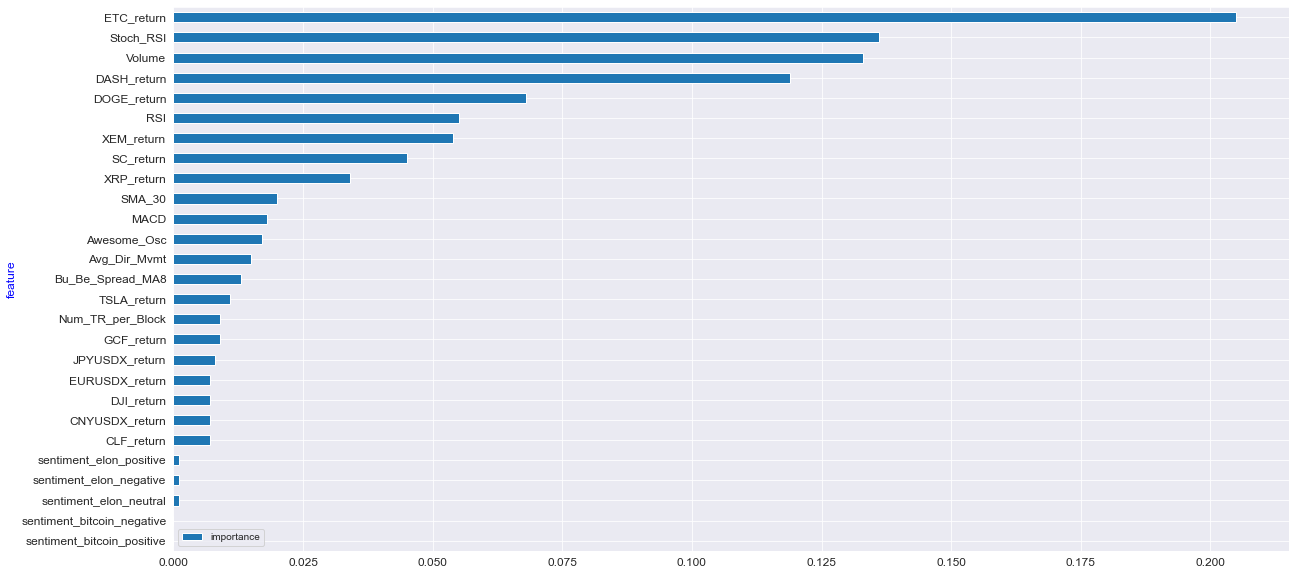

In [127]:
f,ax = plt.subplots(figsize=(20,10)) 
rfc_importances.plot(kind="barh",ax=ax)

### XGBoost Regressor

In [128]:
initial_params['XG Boost Regressor']

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 12,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [129]:
pipe_xgb = Pipeline([("col_transformer", preprocessor), 
                    ('regressor', xgb.XGBRegressor())])

#### Run Cross-Validation with Grid Search

In [130]:
# Setup parameters
objective = ['reg:squarederror']
learning_rate = [0.29, 0.300000012, 0.31]
max_depth = [6, 7, 8, 50]
n_estimators = [1000]
subsample = [1]
min_child_weight = [1]
colsample_bytree = [1]
col_transformer = [preprocessor]


# Hyperparameter Optimization
xgb_grid_search = {'col_transformer': col_transformer,
                    'regressor__objective': objective, 
                    'regressor__learning_rate': learning_rate, 
                    'regressor__max_depth': max_depth, 
                    'regressor__n_estimators': n_estimators, 
                    'regressor__subsample': subsample,
                    'regressor__min_child_weight': min_child_weight,
                    'regressor__colsample_bytree': colsample_bytree
                    }


# Run Grid Serch
scores_grid_xgb = cross_val_score(GridSearchCV(estimator=pipe_xgb,
                                                  param_grid=xgb_grid_search,
                                                  cv=tscv,
                                                  scoring='r2',
                                                  verbose = 0,
                                                  n_jobs = -1), X_train_cv, y_train_cv, cv=tscv)
                         
print("XGB Cross-validation scores (R2): ", scores_grid_xgb)
print("XGB Mean cross-validation score (R2): ", scores_grid_xgb.mean())

XGB Cross-validation scores (R2):  [0.36345935 0.24343732 0.55112978 0.23648941 0.49758646]
XGB Mean cross-validation score (R2):  0.37842046527874523


#### Run Grid Search & Select Best Estimator

In [131]:
# Run Grid Search Fit
clf_xgb_grid = GridSearchCV(estimator=pipe_xgb,
                           param_grid=xgb_grid_search,
                           cv=tscv,
                           scoring='r2',
                           verbose = 0,
                           n_jobs = -1)                         

search_xgb_grid = clf_xgb_grid.fit(X_train_cv, y_train_cv)

In [132]:
pd.set_option('max_colwidth', None)
results_xgb = pd.DataFrame(search_xgb_grid.cv_results_)
results_xgb = results_xgb[['params', 'rank_test_score', 'mean_test_score', 'std_test_score', 
                   'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score']].sort_values(by=['rank_test_score'])
results_xgb[results_xgb['rank_test_score']<=5]

,params,rank_test_score,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,"{'col_transformer': ColumnTransformer(transformers=[('num', Pipeline(steps=[('scaler', StandardScaler())]), Index(['DASH_return', 'DOGE_return', 'ETC_return', 'SC_return', 'XEM_return', 'XRP_return', 'CLF_return', 'CNYUSDX_return', 'DJI_return', 'EURUSDX_return', 'GCF_return', 'JPYUSDX_return', 'TSLA_return', 'Volume', 'SMA_30', 'Num_TR_per_Block', 'Bu_Be_Spread_MA8', 'MACD', 'Avg_Dir_Mvmt', 'RSI', 'Awesome_Osc', 'Stoch_RSI'], dtype='object')), ('cat', Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]), Index(['sentiment_elon', 'sentiment_bitcoin'], dtype='object'))]), 'regressor__colsample_bytree': 1, 'regressor__learning_rate': 0.29, 'regressor__max_depth': 6, 'regressor__min_child_weight': 1, 'regressor__n_estimators': 1000, 'regressor__objective': 'reg:squarederror', 'regressor__subsample': 1}",1,0.476726,0.152841,0.383666,0.243437,0.629606,0.650926,0.475997
1,"{'col_transformer': ColumnTransformer(transformers=[('num', Pipeline(steps=[('scaler', StandardScaler())]), Index(['DASH_return', 'DOGE_return', 'ETC_return', 'SC_return', 'XEM_return', 'XRP_return', 'CLF_return', 'CNYUSDX_return', 'DJI_return', 'EURUSDX_return', 'GCF_return', 'JPYUSDX_return', 'TSLA_return', 'Volume', 'SMA_30', 'Num_TR_per_Block', 'Bu_Be_Spread_MA8', 'MACD', 'Avg_Dir_Mvmt', 'RSI', 'Awesome_Osc', 'Stoch_RSI'], dtype='object')), ('cat', Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]), Index(['sentiment_elon', 'sentiment_bitcoin'], dtype='object'))]), 'regressor__colsample_bytree': 1, 'regressor__learning_rate': 0.29, 'regressor__max_depth': 7, 'regressor__min_child_weight': 1, 'regressor__n_estimators': 1000, 'regressor__objective': 'reg:squarederror', 'regressor__subsample': 1}",2,0.469143,0.204768,0.383129,0.118876,0.601167,0.710287,0.532257
5,"{'col_transformer': ColumnTransformer(transformers=[('num', Pipeline(steps=[('scaler', StandardScaler())]), Index(['DASH_return', 'DOGE_return', 'ETC_return', 'SC_return', 'XEM_return', 'XRP_return', 'CLF_return', 'CNYUSDX_return', 'DJI_return', 'EURUSDX_return', 'GCF_return', 'JPYUSDX_return', 'TSLA_return', 'Volume', 'SMA_30', 'Num_TR_per_Block', 'Bu_Be_Spread_MA8', 'MACD', 'Avg_Dir_Mvmt', 'RSI', 'Awesome_Osc', 'Stoch_RSI'], dtype='object')), ('cat', Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]), Index(['sentiment_elon', 'sentiment_bitcoin'], dtype='object'))]), 'regressor__colsample_bytree': 1, 'regressor__learning_rate': 0.300000012, 'regressor__max_depth': 7, 'regressor__min_child_weight': 1, 'regressor__n_estimators': 1000, 'regressor__objective': 'reg:squarederror', 'regressor__subsample': 1}",3,0.465579,0.153992,0.377293,0.212454,0.635638,0.590625,0.511883
4,"{'col_transformer': ColumnTransformer(transformers=[('num', Pipeline(steps=[('scaler', StandardScaler())]), Index(['DASH_return', 'DOGE_return', 'ETC_return', 'SC_return', 'XEM_return', 'XRP_return', 'CLF_return', 'CNYUSDX_return', 'DJI_return', 'EURUSDX_return', 'GCF_return', 'JPYUSDX_return', 'TSLA_return', 'Volume', 'SMA_30', 'Num_TR_per_Block', 'Bu_Be_Spread_MA8', 'MACD', 'Avg_Dir_Mvmt', 'RSI', 'Awesome_Osc', 'Stoch_RSI'], dtype='object')), ('cat', Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]), Index(['sentiment_elon', 'sentiment_bitcoin'], dtype='object'))]), 'regressor__colsample_bytree': 1, 'regressor__learning_rate': 0.300000012, 'regressor__max_depth': 6, 'regressor__min_child_weight': 1, 'regressor__n_estimators': 1000, 'regressor__objective': 'reg:squarederror', 'regressor__subsample': 1}",4,0.463224,0.141056,0.363459,0.238907,0.594426,0.600882,0.518443
6,"{'col_transformer': ColumnTransformer(transformers=[('num', Pipeline(steps=[('scaler', StandardScaler())]), Index(['DASH_return', 'DOGE_return', 'ETC_return', 'SC_return', 'XEM_return', 'XRP_return', 'CLF_return', 'CNYUSDX_return', 'DJI_return', 'EURUSDX

In [133]:
best_model_xgb = search_xgb_grid.best_estimator_['regressor']

In [134]:
best_model_xgb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.29, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Feature Importance 

Trees based models like RandomForest, XGBoost, etc.  provide us feature importance based on the training.

In [135]:
xgb_model = pipe_xgb['regressor']

In [136]:
pipe_xgb['col_transformer'].transformers_

[('num',
  Pipeline(steps=[('scaler', StandardScaler())]),
  Index(['DASH_return', 'DOGE_return', 'ETC_return', 'SC_return', 'XEM_return',
         'XRP_return', 'CLF_return', 'CNYUSDX_return', 'DJI_return',
         'EURUSDX_return', 'GCF_return', 'JPYUSDX_return', 'TSLA_return',
         'Volume', 'SMA_30', 'Num_TR_per_Block', 'Bu_Be_Spread_MA8', 'MACD',
         'Avg_Dir_Mvmt', 'RSI', 'Awesome_Osc', 'Stoch_RSI'],
        dtype='object')),
 ('cat',
  Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]),
  Index(['sentiment_elon', 'sentiment_bitcoin'], dtype='object'))]

In [137]:
num_feat = list(pipe_xgb['col_transformer'].transformers_[0][2])
cat_feat = list(pipe_xgb['col_transformer'].transformers_[1][1]['onehot'].get_feature_names(categorical_features))

In [138]:
feature_columns = num_feat+cat_feat

In [139]:
xgb_importances = pd.DataFrame(
    {"feature": feature_columns, "importance": np.round(best_model_xgb.feature_importances_, 3)}
)
xgb_importances = xgb_importances.sort_values("importance", ascending=True).set_index(
    "feature"
)

<AxesSubplot:ylabel='feature'>

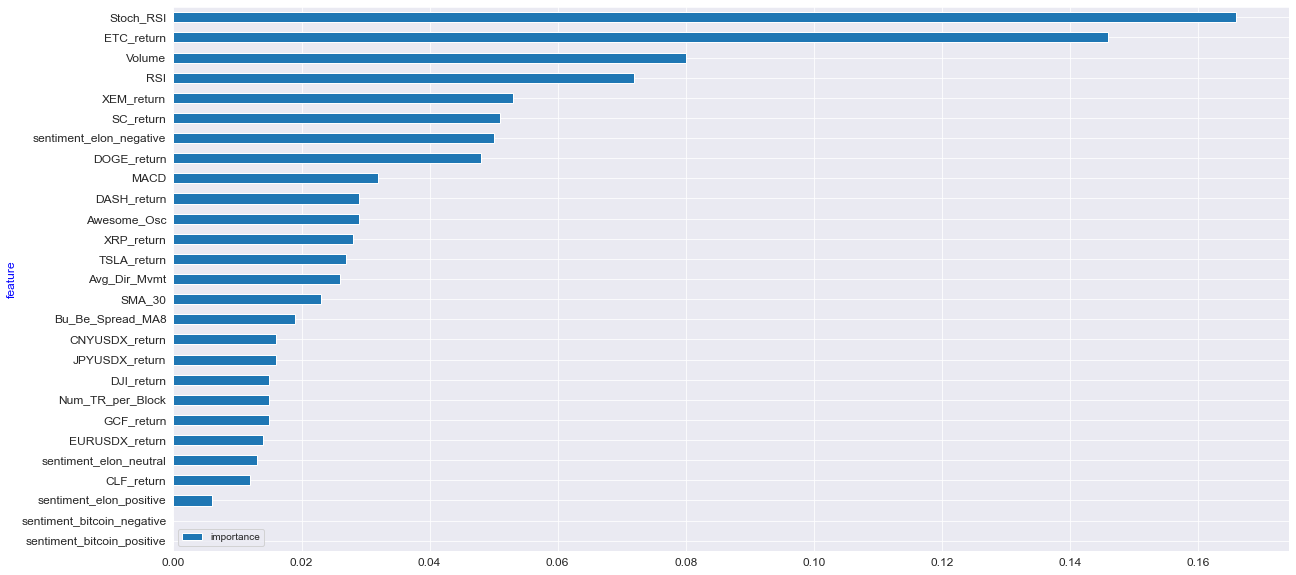

In [140]:
f,ax = plt.subplots(figsize=(20,10)) 
xgb_importances.plot(kind="barh",ax=ax)

### Grid Search Scores

#### Get the best models and their parameters from the Optimization

In [141]:
# Get the best estimator pipelines after fitted Grid Search for the final models
final_models = {
    'Tweedie': search_twd_grid.best_estimator_,
    'SGD': search_sgd_grid.best_estimator_,
    'RandomForest': search_rf_grid.best_estimator_,
    'XGBoost': search_xgb_grid.best_estimator_
 }

In [142]:
# Get the optimized parameters after fitted Grid Search for the final models
final_params = {
    'Tweedie': search_twd_grid.best_params_,
    'SGD': search_sgd_grid.best_params_,
    'RandomForest': search_rf_grid.best_params_,
    'XGBoost': search_xgb_grid.best_params_
 }

In [143]:
# Drop the 'col_transformer' from the parameter grid
def without_keys(d, keys):
    return {k:v for k,v in d.items() if k not in keys}

final_params_cleaned = {}
for name, param_dict in final_params.items():
    dict_cleaned = without_keys(param_dict, 'col_transformer')
    final_params_cleaned[name] = dict_cleaned    

In [144]:
# Create new parameter dictionary with a one-item list for the paramater values
final_params_dict = {}
param_dict = {}

for grid_dict in final_params_cleaned.keys():
    for param, param_value in final_params_cleaned[grid_dict].items():
        param_val_list = []
        param_val_list.append(param_value)
        param_dict[param] = param_val_list
        param_val_list = []
    final_params_dict[grid_dict] = param_dict
    param_dict = {}

#### Get all the relevant Scores from a Cross-Validation of the fitted best tuned Models 

In [145]:
model_names_final = []
score_names_final = []
scores_final = []
scores_means_final = []

scoring_grid_final = ['r2', 'explained_variance', 
                      'neg_mean_absolute_error', 
                      'neg_mean_squared_error', 
                      'neg_root_mean_squared_error']

for est_name, est_model in final_models.items():
    
    # Cross Val Scores
    for score in scoring_grid_final:
        final_grid_score = cross_val_score(GridSearchCV(estimator=est_model,
                                                        param_grid=final_params_dict[est_name],
                                                        cv=tscv,
                                                        scoring=score,
                                                        verbose = 0,
                                                        n_jobs = -1), X_train_cv, y_train_cv, cv=tscv)
        model_names_final.append(est_name)
        score_names_final.append(score)
        if score in ('r2', 'explained_variance'):
            scores_final.append(final_grid_score)
            scores_means_final.append(np.mean(final_grid_score))
        else:
            scores_final.append(-final_grid_score)
            scores_means_final.append(np.mean(-final_grid_score))

In [146]:
df_grid_tscv = pd.DataFrame(score_names_final, 
                             columns=['metric']).merge(pd.DataFrame(scores_means_final, 
                                                                    columns=['score']), 
                                                                    left_index=True, 
                                                                    right_index=True).merge(pd.DataFrame(model_names_final, 
                                                                                                         columns=['model']), 
                                                                                                         left_index=True, 
                                                                                                         right_index=True)

In [147]:
df_grid_scores_tscv = df_grid_tscv.pivot_table('score', ['model'], 'metric')
df_grid_scores_tscv.rename(columns={'explained_variance': 'EVS', 'neg_mean_absolute_error': 'MAE', 
                                    'neg_mean_squared_error': 'MSE', 'neg_root_mean_squared_error': 'RMSE', 'r2': 'R2'}, inplace=True)

In [148]:
df_grid_scores_tscv['traint'] = 'grid search cv'

In [149]:
df_grid_scores_tscv.sort_values(by='R2', ascending=False)

metric,EVS,MAE,MSE,RMSE,R2,traint
model,,,,,,
RandomForest,0.646769,0.016454,0.000570,0.021965,0.646707,grid search cv
SGD,0.526181,0.019858,0.000798,0.026117,0.507810,grid search cv
XGBoost,0.510650,0.020770,0.000898,0.027272,0.476726,grid search cv
Tweedie,0.505442,0.020480,0.000866,0.027075,0.474244,grid search cv


<a name='S'></a>
## <font color='darkblue'>__Select final model and save model artifacts__</font>

### Model Artifacts Definition

In [150]:
# Define the path where the models will be saved
model_path = f"{project_dir}\\02_Saved_Models\\01_Main_Models\\"

In [151]:
# Selected models: Model Artifacts definition
final_model_artifacts = {}

for est_name, est_model in final_models.items():
    num_feat_model = list(est_model['col_transformer'].transformers_[0][2])
    cat_feat_model = list(est_model['col_transformer'].transformers_[1][1]['onehot'].get_feature_names(categorical_features))
    feature_columns_model = num_feat_model+cat_feat_model

    final_model_artifacts[est_name] = {
        'cat_init_features': categorical_features,
        'num_init_features': num_feat_model,
        'cat_ohe_features': cat_feat_model,
        'column_names_order': feature_columns_model,
        'col_transformer': est_model['col_transformer'],
        'final_model': est_model,
    }

### Save model artifacts

In [152]:
for est_name, est_model in final_models.items():
    with open(model_path+'crypto_ml_artifacts_'+est_name+'.pkl', "wb") as dill_file:
        dill.dump(final_model_artifacts[est_name], dill_file)

<a name='P'></a>
## <font color='darkblue'>__Prediction and Testing__</font>

### Load saved Model Artifacts

In [153]:
loaded_model_artifacts = {}
for est_name, est_model in final_models.items():
    with open(model_path+'crypto_ml_artifacts_'+est_name+'.pkl', "rb") as dill_infile:
        artifact_file = dill.load(dill_infile)
        loaded_model_artifacts[est_name] = artifact_file

### Prediction

In [154]:
# We use the test dataset we set aside in the beginning of the Cross-Validation round to make predictions
metrics = {}
predictions ={}

for est_name, est_model in final_models.items():
    # Build the pipeline
    pipeline_built = loaded_model_artifacts[est_name]['final_model']
    # Make prediction
    prediction = pipeline_built.predict(X_test_new)
    predictions[est_name] = prediction
    
    # Calculate the metrics for the "goodness of fit"
    EVS = (explained_variance_score(y_test_new, prediction))
    ME = (max_error(y_test_new, prediction))
    MAE = (mean_absolute_error(y_test_new, prediction))
    MSE = (mean_squared_error(y_test_new, prediction))
    RMSE = np.sqrt(mean_squared_error(y_test_new, prediction))
    R2 = r2_score(y_test_new, prediction)
    Adj_R2 = adjusted_r2_score(y_test_new, prediction, X_test_new)

    metrics[est_name] = {
        'EVS': EVS,
        'ME': ME,
        'MAE': MAE,
        'MSE': MSE,
        'RMSE': RMSE,
        'R2': R2,
        'Adj_R2': Adj_R2
    }

### Evaluation

In [155]:
df_final_test_scores = pd.DataFrame(metrics).round(decimals=4).T

In [156]:
df_final_test_scores['traint'] = 'prediction'

In [157]:
# Final test scores after prediction
df_final_test_scores.sort_values('Adj_R2', ascending=False)

,EVS,ME,MAE,MSE,RMSE,R2,Adj_R2,traint
RandomForest,0.7132,0.1109,0.0132,0.0004,0.0191,0.7073,0.6921,prediction
Tweedie,0.5238,0.1163,0.0167,0.0006,0.0244,0.5221,0.4972,prediction
XGBoost,0.5162,0.1112,0.0174,0.0006,0.0250,0.5001,0.4740,prediction
SGD,0.4886,0.1406,0.0174,0.0006,0.0254,0.4829,0.4559,prediction


In [158]:
# Prepare the initial train/test and cross-validation scores for merge
df_train_test_cv_reset = df_train_test_cv_scores.reset_index()
df_train_test_cv_subset = df_train_test_cv_reset[df_train_test_cv_reset['index'].isin(['Tweedie', 'SGD', 'RandomForest', 'XGBoost'])]
df_train_test_cv_subset.set_index('index', inplace=True)

In [159]:
# Merge the scores
df_metrics_merged = pd.concat([df_final_test_scores, df_grid_scores_tscv, df_train_test_cv_subset])

In [160]:
df_metrics_merged['traint'].replace(
                                   {'training': '01_training',
                                    'initial test': '02_initial_test',
                                    'crossval_tscv': '03_crossval_tscv',
                                    'crossval_btscv': '04_crossval_btscv',
                                    'grid search cv': '05_grid_search_cv',
                                    'prediction': '06_prediction'}, inplace=True)

In [161]:
df_final_metrics = df_metrics_merged.drop(columns=['ME', 'Adj_R2']).sort_values(by='traint')

In [162]:
df_final_metrics = df_final_metrics[['R2', 'MAE', 'EVS', 'MSE', 'RMSE', 'traint']]

In [163]:
df_final_metrics

,R2,MAE,EVS,MSE,RMSE,traint
XGBoost,0.999000,0.000800,0.999000,0.000000,0.001100,01_training
Tweedie,0.512000,0.017100,0.512000,0.000600,0.025000,01_training
SGD,0.553600,0.017000,0.553700,0.000600,0.023900,01_training
RandomForest,0.952200,0.005200,0.952200,0.000100,0.007800,01_training
XGBoost,0.603500,0.015900,0.608500,0.000500,0.022300,02_initial_test
RandomForest,0.718700,0.012600,0.720700,0.000400,0.018700,02_initial_test
Tweedie,0.524300,0.016600,0.524800,0.000600,0.024400,02_initial_test
SGD,0.240500,0.021800,0.349400,0.000900,0.030800,02_initial_test
XGBoost,0.463224,0.021315,0.492481,0.000909,0.027561,03_crossval_tscv
Tweedie,0.474244,0.020480,0.505442,0.000866,0.027075,03_crossval_tscv


<a id='X'></a>
## <font color='darkblue'>__Compare model performance metrics__</font>

In [164]:
# Define a function for the coloring by values
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

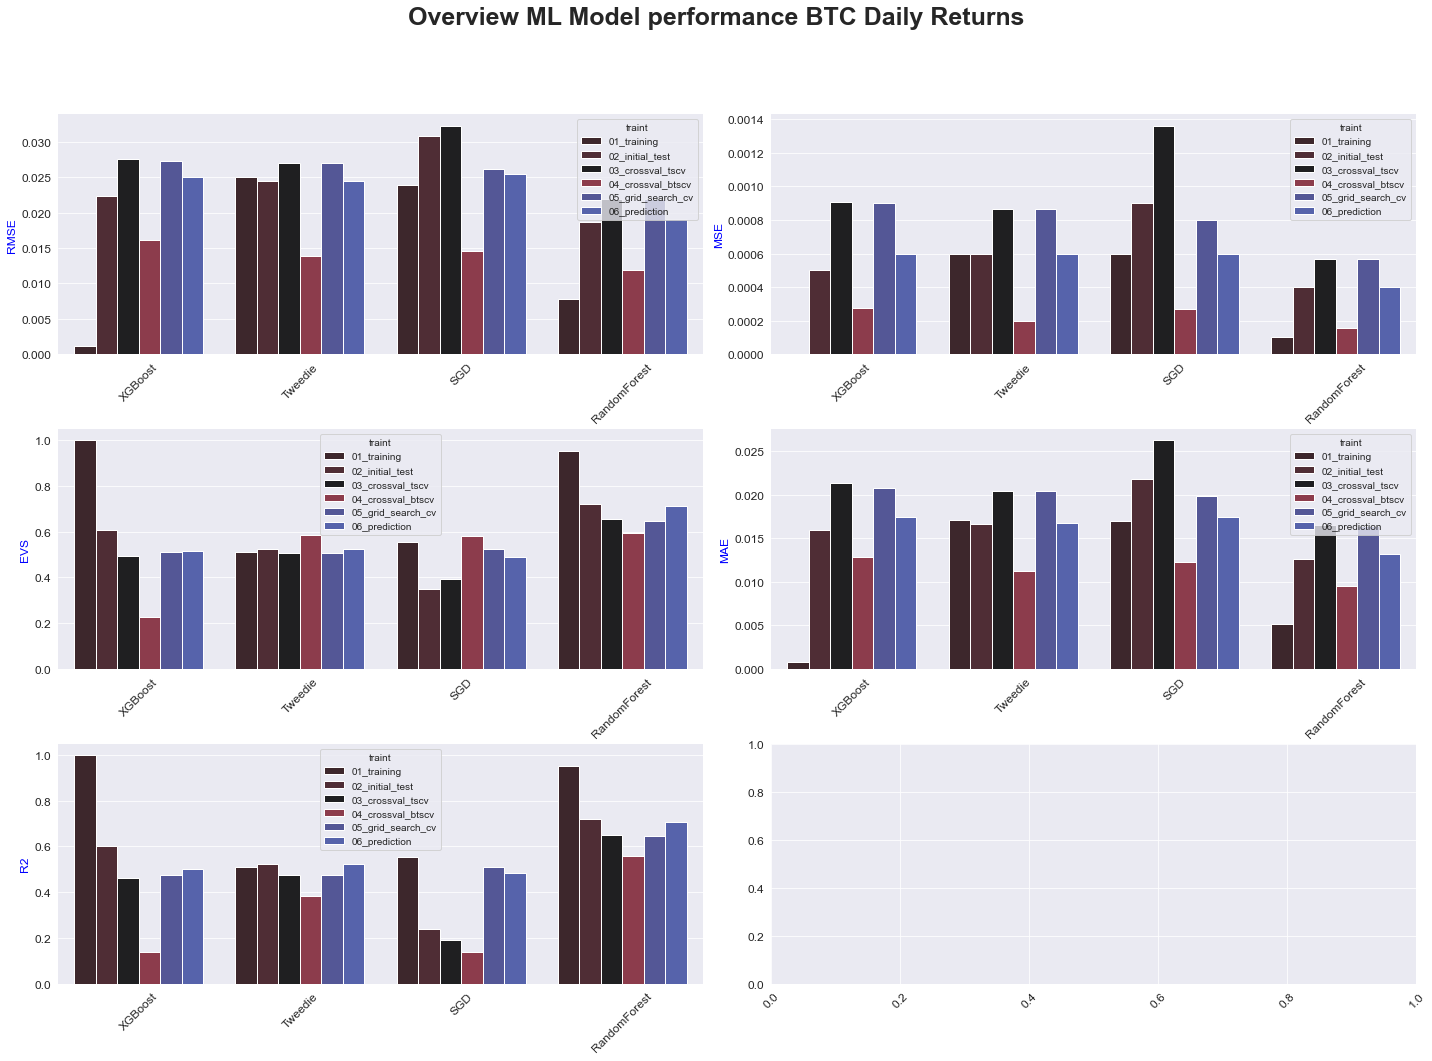

In [165]:
# Plot the final model performance
final_score_col = set(df_final_metrics.columns) - set(['traint'])

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20,15))
for feat_num, feat_name in enumerate(final_score_col):
    sns.barplot(data=df_final_metrics, x=df_final_metrics.index, y=df_final_metrics[feat_name],
                hue='traint', ax=axs[int(feat_num/2), feat_num%2], 
                palette=colors_from_values(y, "icefire"))
    sns.despine(left=True)
for ax, dat in zip(axs.ravel(), df_final_metrics):
    ax.tick_params(axis='x', labelrotation=45)
plt.tight_layout()
plt.suptitle("Overview ML Model performance BTC Daily Returns", fontsize = 25, fontweight = 'bold')
fig.subplots_adjust(top=0.88)
plt.show()

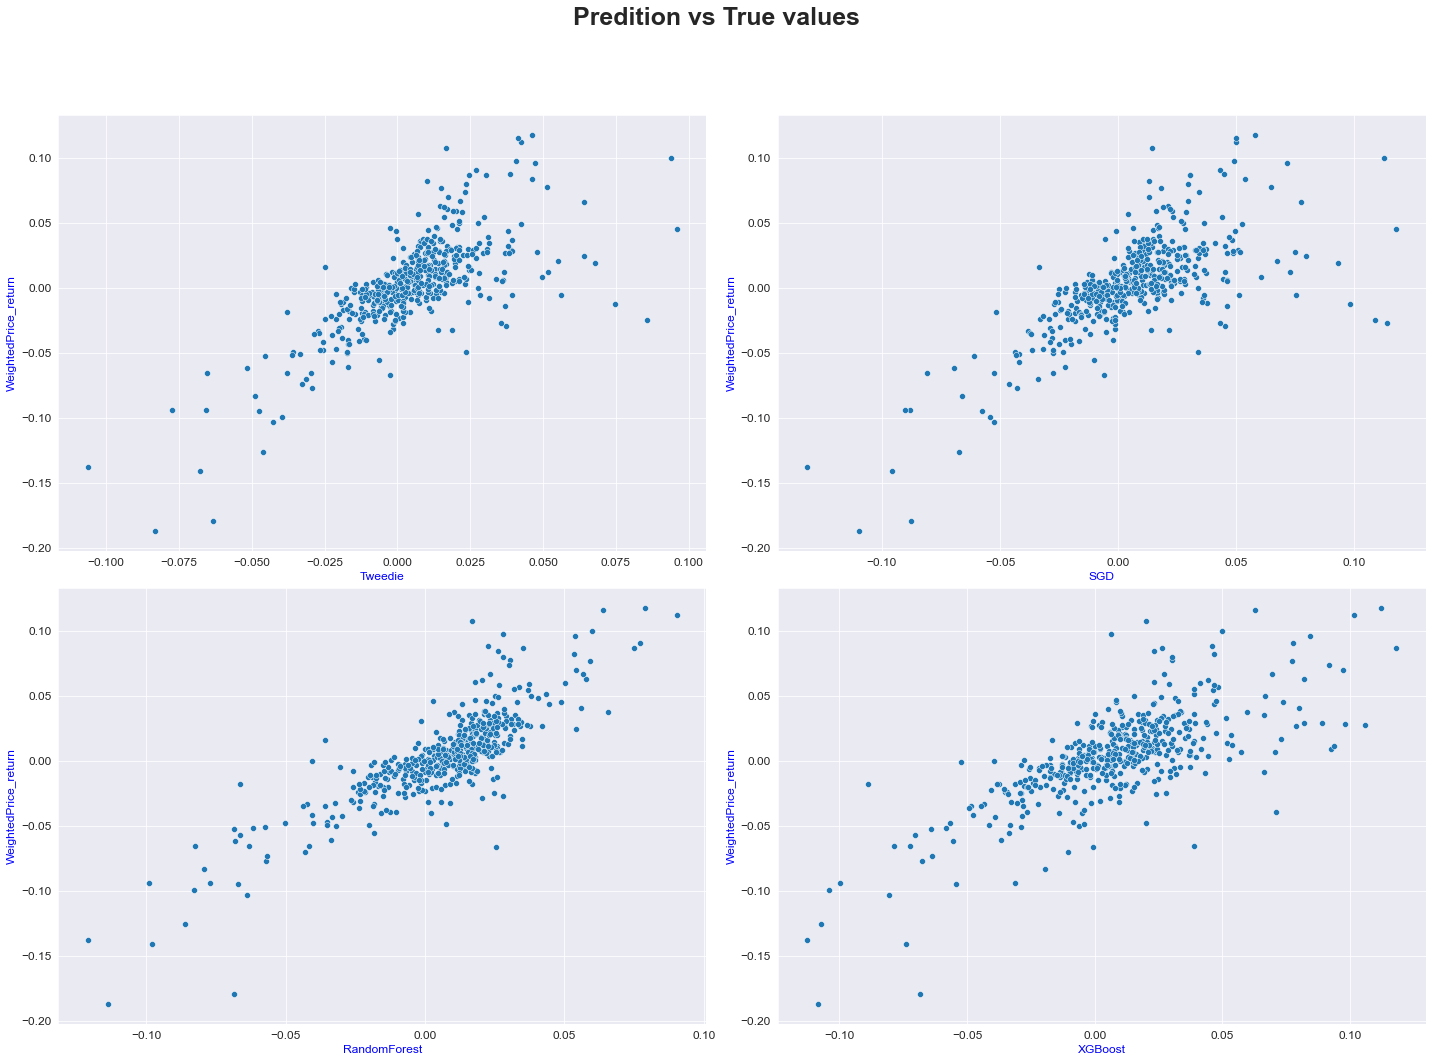

In [166]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20,15))
for num, name in enumerate(final_models):
    ax = sns.scatterplot(predictions[name], y_test_new, ax=axs[int(num/2), num%2])
    ax.set(xlabel=name)

plt.tight_layout()
plt.xlabel(name)
plt.suptitle("Predition vs True values", fontsize = 25, fontweight = 'bold')
fig.subplots_adjust(top=0.88)
plt.show()

### Appendix

In [167]:
# Method to compute the variance
def calculate_varaince_of_model(samplePredictions, y_test):
    predictions_mean_model = samplePredictions.mean(axis =1)
    colNames = samplePredictions.columns
    variance = np.zeros(len(colNames))
    i = 0
    for colName in colNames:
        variance[i] = np.mean(np.square(samplePredictions[colName] - predictions_mean_model))
        rmse = mean_squared_error(y_test, samplePredictions[colName])
        i += 1
    return round(np.mean(variance),3), round(np.mean(rmse),3)

In [168]:
# Method to compute the bias
def calculate_bias_of_model(samplePredictions, y_hat_pop):
    return np.square((np.abs(samplePredictions.mean(axis=1) -y_hat_pop).mean()))